## ETC updates:

12/17/20: change input to band r for visible for scorpio, keep same input spectrum


12/18/20: background is now operating in slitless mode

1/7/21: not operating in slitless mode, currently working on scatter plot for filter

1/14/21: applying filter into the ETC background calculation, NOT YET switch to slitless

1/21/21: switching to slitless, put final graphing into a function
- currently, this script does NOT have any of the test SNR calculations, or random signal/noise plots. Look to Serena_multiband_visible-trygauss for those plots
- currently, this script DOES have:
    - ETC without filter, slit
    - ETC with fliter, slit
    - ETC without filter, slitless
    - ETC without filter, slitless
    - all the scatter plots and new SNR calculations for each


1/29/21: testing out new grating. this script currently has: 
- random sig/noise plots
- all 4 ETC plots
- scatter plots normalized and correct SNR calculations for slit and slitless with filter calculations

need to do: new grating, put background filter into a function, put all functions in one place and all calculations elsewhere

2/12/21: 
- has new settings for slitless for samos (based on new gratings)

2/17/21: 
- fixed lowblue/lowred issue (they were backwards)
- got rid of everything but SAMOS related settings
- working on fixing bkg filter

2/19/21:
- fixed bkg filter
- getting rid of other ETC filter tests, just keeping slitless mode
- currently creating pretty graphs (slitless mode)
- then will test new grism settings for slitless (currently testing with normal settings, except in user input where theta = same as slitwidth setting

In [113]:
import os
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip, mad_std

init_notebook_mode(connected=True)

#reload
import sys
from scipy.signal import find_peaks
import scipy.signal as sp_sig
from scipy.ndimage import gaussian_filter

### Read the throughput files

All tables are COLUMNS x ROW, i.e. (100 x 2) or .shape=>(100,2)
- this is the standard format of those read by file
- those written explicitely below may need to be transposed (i.e. lam1...lamN must be a column)

[[0.4  0.4 ]
 [0.5  0.67]
 [0.6  0.67]
 [0.7  0.55]
 [0.8  0.45]
 [0.9  0.37]]


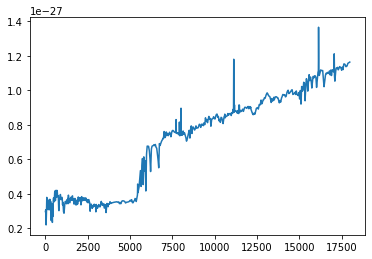

In [168]:
#reading the files

homedir = os.path.join(os.getcwd(),"etc_data")

#Throughput
#==============================================================================
#0) Metals for telescope optics (and possibly other mirrors)
# Al from National Bureau of Standards, certainly optimistic
Al_reflectivity = np.loadtxt(os.path.join(homedir,"general/coating_throughput","Al_reflectance_NBS.txt")) #lambda[nm], transmission
Al_reflectivity[:,0] =  Al_reflectivity[:,0] * 1E-3 #nm -< [micron]
#Al_reflectivity.shape #(25,2)

#For Gemini, measured on site, average
Silver_reflectivity = np.loadtxt(os.path.join(homedir,"general/coating_throughput","SilverCoating_ALL.txt")) #lambda[nm], transmission
Silver_reflectivity[:,0] =  Silver_reflectivity[:,0] * 1E-3 #nm -< [micron]
#Silver_reflectivity.shape  # (221,2)

#;  if telescope EQ 'GEMS f/33' then throughput*=0.7
#  throughput*=0.9

#1) Instruments
#B) SAMOS
#SAM throughput
SAM_wl = [0.4,1.0]
SAM_th = [0.9,0.9]

#SAMOS_throughput_OPTICS 
SAMOS_wl_th = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
SAMOS_Optics_th  = [0.692, 0.770, 0.793, 0.793, 0.787, 0.792, 0.796, 0.794, 0.703]
SAMOS_Optics_throughput = np.transpose(np.array([SAMOS_wl_th,SAMOS_Optics_th]))
#SAMOS_Optics_throughput.shape (9,2) 

#SAMOS_throughput_SAMI
SAMI_CCD_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
SAMI_CCD_QE     = [0.679, 0.875, 0.879, 0.836, 0.865, 0.885, 0.885, 0.834, 0.677]
SAMOS_CCD_throughput = np.transpose(np.array([SAMI_CCD_wl,SAMI_CCD_QE]))
#SAMOS_CCD_throughput.shape # (9,2)

#SAMOS_throughput_DMD
DMD_efficiency_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
DMD_efficiency_table   = [0.667, 0.680, 0.680, 0.680, 0.680, 0.680, 0.680, 0.680, 0.667]
SAMOS_DMD_throughput = np.transpose(np.array([DMD_efficiency_wl,DMD_efficiency_table]))

#SAMOS_throughput_VPH
Blue_VPH_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
Blue_VPH_th      = [0.679, 0.875, 0.879, 0.836, 0.685, 0.   , 0.   , 0.   , 0.   ]
SAMOS_LowBlueVPH_throughput = np.transpose(np.array([Blue_VPH_wl,Blue_VPH_th]))
Red_VPH_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
Red_VPH_th       = [0.   , 0.   , 0.   , 0.   , 0.685, 0.885, 0.885, 0.834, 0.677]
SAMOS_LowRedVPH_throughput = np.transpose(np.array([Red_VPH_wl,Red_VPH_th]))
Ha_VPH_wl      = np.array([0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71]) * 1E3 #;nm
Ha_VPH_th      = [0.73, 0.80, 0.87, 0.92, 0.95, 0.97, 0.97, 0.96, 0.93, 0.90, 0.84, 0.78, 0.71]
SAMOS_HighRedVPH_throughput = np.transpose(np.array([Ha_VPH_wl,Ha_VPH_th]))


#new gratings, not sure how to put this here
#convert to np array

# wl span; µm?
LowWhite_VPH_wl = np.array([.4, 0.5,0.6,0.7,0.8,0.9]) #,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]) #; i think already in micron
    #true for all

# to what SI digit
# 54-*-750
LowWhite_VPH_th = np.array([40, 67, 67, 55, 45, 37]) / 100#, 30, 25, 21, 18, 14, 12, 11, 9, 8, 6, 5]) /100
SAMOS_LowWhiteVPH_throughput = np.transpose(np.array([LowWhite_VPH_wl,LowWhite_VPH_th]))
print(SAMOS_LowWhiteVPH_throughput)


#54-*-751R
newgrating_751 = np.array([2, 35, 69, 80, 75, 68, 60, 52, 44, 39,32, 29, 26, 22, 20, 17, 15]) /100

#54-*-906
newgrating_906 = np.array([14, 61, 80, 77, 68, 59, 50, 43, 36, 30, 26, 23, 20, 18, 15, 13, 12]) /100




#Atmospheric Transmission
#==============================================================================
AtmosphericExtinction_IR = np.loadtxt(os.path.join(homedir,"general/AtmosphericExtinction","Extinction_IR.txt"),skiprows=1) #lambda[micron], transmission
#AtmosphericExtinction_IR = np.transpose(AtmosphericExtinction_IR) #[micron, throughput]
#AtmosphericExtinction_IR.shape # (2,16198)
AtmosphericExtinction_IR[:,0] = AtmosphericExtinction_IR[:,0] *1E-4 # A => [micron]
AtmosphericExtinction_VIS = np.loadtxt(os.path.join(homedir,"general/AtmosphericExtinction","Extinction_VIS.txt"),skiprows=1) #lambda[micron], transmission
#AtmosphericExtinction_VIS = np.transpose(AtmosphericExtinction_VIS) #[micron, throughput]
#AtmosphericExtinction_VIS.shape # (2,7199)
AtmosphericExtinction_VIS[:,0] = AtmosphericExtinction_VIS[:,0] *1E-4 # A => [micron]

#==============================================================================
#Bandpasses
#==============================================================================

#B) SAMOS
#a1 = (np.array([x for x in range(2001)])+4000)*1E-4  # [micron]
#a2 = np.array([1]*2001)
#spec_bandpass_LowBlue=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(3501)])+6000)*1E-4  # [micron]
#a2 = np.array([1]*3501)
#spec_bandpass_LowRed=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(636)])+4504)*1E-4  # [micron]
#a2 = np.array([1]*636)
#spec_bandpass_HighBlue=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(1013)])+5988)*1E-4  # [micron]
#a2 = np.array([1]*1013)
#spec_bandpass_HighRed=np.transpose(np.array([ a1, a2 ]))

SAMOS_bandpass_LowBlue = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Blue.txt")) #lambda[micron], transmission
#SAMOS_bandpass_LowBlue = np.transpose(SAMOS_bandpass_LowBlue)
SAMOS_bandpass_LowRed = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Red.txt")) #lambda[micron], transmission
#SAMOS_bandpass_LowRed = np.transpose(SAMOS_bandpass_LowRed)
SAMOS_bandpass_HighBlue = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Hb.txt")) #lambda[micron], transmission
#SAMOS_bandpass_HighBlue = np.transpose(SAMOS_bandpass_HighBlue)
SAMOS_bandpass_HighRed = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Ha.txt")) #lambda[micron], transmission
#SAMOS_bandpass_HighRed = np.transpose(SAMOS_bandpass_HighRed)
# SAMOS_bandpass_HighRed.shape # (2,4)

SAMOS_bandpass_LowWhite = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_White.txt")) #lambda[micron], transmission)



#Background
#==============================================================================


#B) SAMOS 
loghc = -15.701922659
SAMOS_AtmosphericEmission_VIS = np.loadtxt(os.path.join(homedir,"general/AtmosphericEmission/Paranal","UVES_Fluxed_SkyALL.txt")) #lambda [A]; [erg/sec/cm2/A/arcsec2]
SAMOS_AtmosphericEmission_VIS[:,0] =  SAMOS_AtmosphericEmission_VIS[:,0] * 1E-4 #A -> [micron]
SAMOS_AtmosphericEmission_VIS[:,1] =  SAMOS_AtmosphericEmission_VIS[:,1] * (10.**(-loghc) * SAMOS_AtmosphericEmission_VIS[:,0] * 1E-4) * 1E4 * 1E-1# erg/sec/cm2/A/arcsec2 => [ph/sec/m2/nm/arcsec2]

#plt.plot(SCORPIO_AtmosphericEmission_VIS[:,0],SCORPIO_AtmosphericEmission_VIS[:,1])
    #why is there such a large jump??

#Source
#A) ATLAS
userspec = np.loadtxt(os.path.join(homedir,"templates","Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt"))
            # source spectrum "userspec" is in [erg/s/cm2/Hz]
            # it is organized by ROWs: lam0... lamN  -> userspec[:,0]
            #                          flx0... flxN  -> userspec[:,1]

plt.plot(userspec[:,1])



In [138]:
#telescope_file = open(os.path.join(homedir,"telescope","telescope_data_atlas_IR.txt"),'r')
#telescope = telescope_file.read()
#maybe should put in dictionary first
def set_telescope_instrument(userinput):
    if userinput["telescope"] == 'SOAR':
        telescope = {
            "AT":((400/2.)**2 * np.pi),	# Area of the telescope ((410/2.)**2 * np.pi) [cm2]
            "Nmirror":3,		# Number of SOAR mirrors, silver coated 
            "Mref":1.0		# Mirror reflectance (reflectance already included in spectroscopic throughput)
            }

    if userinput["instrument"] == 'SAMOS':
        instrument = {
            "sat_limit":92450,	# saturation limit [e-]
            "sat_limit_other": 92450,
            ## other instrument parameters 
            "slit_W":0.1667*2,	# SAMOS DMD scale is 0.1667". Nominal slit width is 2 mirrors
            "pix_scale": 0.1667*1.125,	# spatial pixel scale [arcsec/px] - Sample 2 mirrors with 2.25 CCD pixels
            "tot_Npix":4096-1215,	# Number of pixels in dispersion direction on the detector (FoV=1215pix)
            ## detector parameters
            "det_RN":5,		# Detector readnoise (correlated double sampling) [e-/px]
            "dark":0.005,	# dark current [e-/s]
             ## Channel parameters 
            "disp_LowRed": (9500.-6000.)/2874.0,	# dispersion [angstrom/px]
            "disp_LowBlue":  (6000.-4000.)/2875.0,	# dispersion [angstrom/px]
            "disp_HighBlue":(5139.-4504.)/2876.0,	# dispersion [angstrom/px]
            "disp_HighRed": (7000.-5988.)/2876.0,	# dispersion [angstrom/px]
            "lambda_LowBlue": 0.4965,		# central wavelength [microns]
            "lambda_LowRed":  0.7712,		# central wavelength [microns]
            "lambda_HighBlue":0.4803,		# central wavelength [microns]
            "lambda_HighRed": 0.6472,		# central wavelength [microns]
            "intrinsic_res_LowBlue": 3137. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_LowRed" : 2791. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_HighBlue": 9601. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_HighRed" : 8111. * 0.1667*2, # instrument["slit_W"] 
             #for slitless mode
            "slitless_W": 1, #arcsec
            "tot_Npix_slitless": 433, # from ppt
            "disp_LowWhite": (9000-4000)/433, # [angstrom/px] > 433 comes from imaging channel, not spectrographic channel
            "lambda_LowWhite": 0.65, # from ppt
            "intrinsic_res_LowWhite": 225 * 1 #from ppt, *1 because no slit
            }
        
 
    output = {"telescope":telescope, "instrument":instrument}
    return(output)


#ret = set_telescope_instrument(userinput)
#print(ret['telescope']['Nmirror'],ret['instrument']['lambda_J'])

In [139]:
#double check
#purpose is to mimic what output would look like based on the inherent flaws of optics of telescope
#basic process: convert everything to velocity, make a gaussian kernal and convolve it with the rest of the function, 
#               then convert back to wavelength

def degrade_resolution(wavelengths, flux, center_wave, spec_res, disp, px_tot):    
#    print('in degrade resolution')
#    print(wavelengths, flux, center_wave, spec_res, disp, px_tot)
#[1.5  1.76] [1. 1.] 
#1.63 
#0.40471199999999996 1.34252 4096
    #allow more px for K band  
    Npix_spec=px_tot * 3./2.  # if px_tot=4096, this is 6144 pixels

    #the log of speed of light in cm/s
    logc=np.log10(29979245800.)  

    # make velocity array from -300,000 to 300,000 Km/s
    vel=(np.arange(600001)-300000) # big array of integers....
    
    # the array of wavelengths coming in input is converted in velocity difference vs. central wavelength, in km/s
    in_vel=(wavelengths/center_wave-1)*10.**(1*logc-5) 

    # we can get non-physical velocities: kill them and their relative input flux array
    #create vectors in velocity space, picking out realistic values (keeping good indices)
    in_vel_short = in_vel[ np.where( (in_vel > vel[0]) & (in_vel < vel[600000]) )[0] ]
    in_flux_short = flux[ np.where( (in_vel > vel[0]) & (in_vel < vel[600000]) )[0] ] 
        
    # this new arrays of velocities from the center_wave, and relative fluxes, are not uniformly sampled...
    # interpolate to equally spaced km/s, i.e. 600000 points
    interp_flux = np.interp(vel, in_vel_short, in_flux_short)
#    print(interp_flux,vel, in_vel_short, in_flux_short) 
#[1. 1. 1. ... 1. 1. 1.] [-300000 -299999 -299998 ...  299998  299999  300000] [-23909.82793865  23909.82793865] [1. 1.]
    
    # sigma  = the resolution of the spectrograph in km/s, expressed as sigma of the Gaussian response.
    # it is Delta_lam/lam = Delta_v/c = FWHM/c = 2SQRT(2log2)/c, since
    # FWHM = 2*SQRT(2*log2) = 2.35
    sigma = (10.**(logc-5)/spec_res)/(2*np.sqrt(2*np.log(2))) 
    #for R=1000 it is sigma = 127.31013507066515 [km/s]; instead of 300km/s, that would be the FWHM
    # make a smaller velocity array with
    # the same "resolution" as the steps in
    # vel, above
    n = round(8.*sigma) # = 1012kms    
    # make sure that n is even...
    if (n % 2 == 0):
        n = n + 1
    #create an array -4*sigma to +4*sigma in km/s, e.g. from -509 to +508   
    vel_kernel = np.arange(n) - np.floor(n/2.0)

    # create a normalized gaussian (unit area) with width=sigma
    gauss_kernel = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*vel_kernel**2.0/sigma**2.0)
        # shape the kernel
        # look up the equation for gaussian kernal and figure out the significance of sigma used here
        # like how does resolution shape/define the kernel
#    print(sigma,vel_kernel,gauss_kernel)
#314569.7065336959 
#[-1258279. -1258278. -1258277. ...  1258277.  1258278.  1258279.] 
#[4.25438073e-10 4.25443483e-10 4.25448893e-10 ... 4.25448893e-10 4.25443483e-10 4.25438073e-10]    
    # convolve flux with gaussian kernel
    convol_flux = np.convolve(interp_flux, gauss_kernel , mode="same") 
    # convert old moving kernel
    convol_wave = center_wave * (vel*10.**(-1*logc+5.0) + 1.0 ) # [micron]
    # convert back to wavelength 

    # and the real pixel scale 
    real_wave = np.arange(Npix_spec) * disp * 10.**(-4.)     #6000pix * 10A/pix * 1E-4mic/A  => [micron]
    real_wave = real_wave - real_wave[int(np.round(Npix_spec/2.))]   
    real_wave = real_wave + center_wave # [pixel]    print(real_wave)
    # wavelength to px

    # interpolate onto the pixel scale of the detector
    out_wave = real_wave
#    print('out_wave',out_wave)
    out_flux = np.interp(real_wave , convol_wave, convol_flux)
        # interpolating to number of px (b/c working from km/px or lam/px)
    
    out = {"lam": out_wave, #[micron]
          "flux": out_flux} #same unit in input e.g. erg/cm2/s/micron
    
    return(out)
    

### ETC Function 
- 1/14/21: currently running slit mode
- 1/19/21: choice of slit or slitless


In [155]:

def general_etc_serena(userinput, filtered=False, bandpass_filter=[], slitless_mode=False):
    # General Constants 
    logc = np.log10(29979245800) # speed of light in cm/2
    hplank = np.log10(6.626068)-27 # Plank constant in erg*s
    loghc = logc + hplank # h*c in log(erg * cm)
    f_nu_AB = 48.59

    if userinput["nExp"] > 1:
        dither = 2.0
    else:
        dither = 1.0  
##---------------------------------------------------------------------------------------------------------       
##---------------------------------------------------------------------------------------------------------          
    ##-----throughput calculation-------##
##---------------------------------------------------------------------------------------------------------       
    #throughput of instrument + telescope with mirrors taken into account
    #throughput file is the mirror reflectivity [Mref] ^ nr. of mirrors [Nmirror]
    #in the formula below Mref=1;  

    
##---------------------------------------------------------------------------------------------------------       
    if userinput["telescope"] == "SOAR":
        th_tel_lambda = Al_reflectivity[:,0]   #wl in [micron], sparsely sampled
        th_tel_eff = Al_reflectivity[:,1] ** telescope["Nmirror"]    # 3 reflections, Al mirrors
        #
        if userinput["instrument"] == "SAMOS":
            th_ins_lambda = np.array(SAMOS_wl_th)  # nm -> [micron]
            print(SAMOS_Optics_throughput.shape,SAMOS_DMD_throughput.shape,SAMOS_CCD_throughput.shape,AtmosphericExtinction_VIS.shape)
            th_ins_eff = SAMOS_Optics_throughput[:,1] * SAMOS_DMD_throughput[:,1] * SAMOS_CCD_throughput[:,1] 
            #
            #ground based, visible instrument:
            bkg = SAMOS_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
            print(bkg.shape)
            
            #
            tot_Npix = instrument["tot_Npix"]
            if userinput["band"] == "LowRed":
                VPH_wl = SAMOS_LowRedVPH_throughput[:,0]
                VPH_th = SAMOS_LowRedVPH_throughput[:,1]
                resolving_power = instrument["intrinsic_res_LowRed"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_LowRed"]
                ins_disp = instrument["disp_LowRed"]
                spec_bandpass = SAMOS_bandpass_LowRed
            elif userinput["band"] == "LowBlue":
                VPH_wl = SAMOS_LowBlueVPH_throughput[:,0]
                VPH_th = SAMOS_LowBlueVPH_throughput[:,1]
                print("VPH_wl: ", VPH_wl)
                print("VPH_th: ", VPH_th)
                resolving_power = instrument["intrinsic_res_LowBlue"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_LowBlue"]
                ins_disp = instrument["disp_LowBlue"]
                spec_bandpass = SAMOS_bandpass_LowBlue
            elif userinput["band"] == "HighRed":
                VPH_wl = SAMOS_HIGHRedVPH_throughput[:,0]
                VPH_th = SAMOS_HighRedVPH_throughput[:,1]
                resolving_power = instrument["intrinsic_res_HighRed"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_HighRed"]
                ins_disp = instrument["disp_HighRed"]
                spec_bandpass= SAMOS_bandpass_HighRed
            elif userinput["band"] == "LowWhite":
                VPH_wl = SAMOS_LowWhiteVPH_throughput[:,0] 
                VPH_th = SAMOS_LowWhiteVPH_throughput[:,1] 
                resolving_power = instrument["intrinsic_res_LowWhite"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_LowWhite"]
                ins_disp = instrument["disp_LowWhite"]
                spec_bandpass = SAMOS_bandpass_LowWhite 
            else:
                print("Something is wrong with the insrument or the observing mode")
#            print(spec_bandpass)
            x0 = spec_bandpass[0,0]*1E4
            x1 = spec_bandpass[1,0]*1E4
            xrange = np.int(x1-x0+1)
            wl = (np.array([x for x in range(xrange)])+x0)*1E-4  # [micron]    
            #print(wl)
            throughput_all = np.interp(wl, AtmosphericExtinction_VIS[:,0],AtmosphericExtinction_VIS[:,1]) * \
                             np.interp(wl, th_tel_lambda, th_tel_eff) * \
                             np.interp(wl, th_ins_lambda, th_ins_eff) * \
                             np.interp(wl, VPH_wl, VPH_th)
            throughput_all_no = np.interp(wl, AtmosphericExtinction_VIS[:,0],AtmosphericExtinction_VIS[:,1]) * \
                             np.interp(wl, th_tel_lambda, th_tel_eff) * \
                             np.interp(wl, th_ins_lambda, th_ins_eff)
            print("throughput_all = ", throughput_all)
            print("throughput_all_no = ", throughput_all_no)

            #print(th_ins_lambda, th_ins_eff)
            #throughput = throughput_all
            throughput=np.transpose(np.array([wl,throughput_all]))
            print("throughput again:",throughput)
            plt.plot(th_tel_lambda, th_tel_eff)
            plt.plot(wl, np.interp(wl, th_tel_lambda, th_tel_eff))
            plt.plot(th_ins_lambda, th_ins_eff)
            plt.plot(wl,np.interp(wl, th_ins_lambda, th_ins_eff))
            plt.plot(VPH_wl, VPH_th)
            plt.plot(wl,np.interp(wl, VPH_wl, VPH_th))
            plt.plot(wl,throughput_all)
            plt.show()

    ##------degrade resolution-------##
##---------------------------------------------------------------------------------------------------------       
#    print('spec_bandpass[:,0]',spec_bandpass[:,0])
    ##bandpass   
    bandpass_degrade = degrade_resolution(wavelengths=spec_bandpass[:,0], 
                                        flux=spec_bandpass[:,1], 
                                        center_wave=ins_lambda, 
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
    

    
    #get the relevant portion (limits make sense after run through the degrade function)
    relevant_indices = np.where(bandpass_degrade['flux'] > 0.1)[0]
    print("relevant indices shape:", relevant_indices.shape)
    
    bandpass_degrade["lam"] = np.array(bandpass_degrade["lam"][relevant_indices])
    bandpass_degrade["flux"] = np.array(bandpass_degrade["flux"][relevant_indices])

    bandpass_index = np.where(bandpass_degrade["flux"] > 0.5)[0]
    print("bandpass_index shape:", bandpass_index.shape)
    print("bandpass_index numbers:", bandpass_index)

#    print('relevant_indices',relevant_indices)
#    print('bandpass_degrade',bandpass_degrade)
#    print('1 bis) throughput[:,0]',throughput[:,0],throughput[:,0]) 
#    print('2P throughput[:,0]',throughput[:,0])
#    print(throughput[:,1])
#    print('others',ins_lambda,resolving_power,ins_disp,instrument["tot_Npix"])

    ##throughput
    #relevant_indices = np.where(throughput[:,1] > 0.)[0]
    #throughput[:,0] = np.array(throughput[:,0][relevant_indices])
    #throughput[:,1] = np.array(throughput[:,1][relevant_indices])
#    print('throughput 3',throughput)
    throughput_degrade = degrade_resolution(wavelengths=throughput[:,0], 
                                        flux=throughput[:,1], 
                                        center_wave=ins_lambda,  
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
    
    print("throughput degrade = ", throughput_degrade)

    
#    print(throughput[:,0])
#    print(throughput[:,1])
    print("Throughput_degrade pre truncation = ", throughput_degrade["flux"].shape)
    #get relevant portions
    throughput_degrade["lam"] = throughput_degrade["lam"][relevant_indices]
    throughput_degrade["flux"] = throughput_degrade["flux"][relevant_indices]
    print("Throughput_degrade post truncation = ", throughput_degrade["flux"].shape)
    
        ## insert filter for "raw" data, throughput
    if filtered:
        throughput_degrade["flux"] = throughput_degrade["flux"]*bandpass_filter
    

    
#    print('bkg[:,0]',bkg[:,0])
    ##background
    background_degrade = degrade_resolution(wavelengths=bkg[:,0], 
                                        flux=bkg[:,1], 
                                        center_wave=ins_lambda, 
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
    print("Background_degrade pre truncation = ", background_degrade["flux"].shape)
    #set negative values to 0
    where_zero = np.where(background_degrade["flux"] < 0)[0]
    background_degrade["flux"][where_zero] = 0

    
    background_degrade["lam"] = background_degrade["lam"][relevant_indices]
    background_degrade["flux"] = background_degrade["flux"][relevant_indices]
    print("Background_degrade post truncation = ", background_degrade["flux"].shape)
    
        ## insert filter for "raw" data, background
    if filtered:
        background_degrade["flux"] = background_degrade["flux"]*bandpass_filter
    
    plt.plot(bkg[:,0],bkg[:,1])
    plt.plot(background_degrade["lam"],background_degrade["flux"])

    # do the check single line input 
##---------------------------------------------------------------------------------------------------------    
    # include conversion to micron from ang
    # include z shift
    # include check that input wavelength is within range
   
    #check line > if the user wants to know a specific line width, one has to set:
        # 1) lineF
        # 2) lineW
        # 3) no specFile
##---------------------------------------------------------------------------------------------------------    
    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0) & (userinput["specFile"] == "none"):
        SPECTYPE = "line"

        # Convert from ang to micron
        if userinput["InputInAngstroms"] == True:
            userinput["lineW"] = userinput["lineW"]/10000   # [micron] Equivalen Width  

        # Apply redshift, from local to observed frame
        center_w = userinput["lineW"] * (1+userinput["z"])   # [micron[]

        # Check to see if the band is correct, check the central wavelength [micron] vs. bandpass
        if (center_w > np.nanmax(spec_bandpass[:,0])) | (center_w < np.nanmin(spec_bandpass[:,0])):
            print("This wavelength is not contained in the band")

    # check spectrum > if the user wants to view an entire spectrum: 
        # 1) specFile must be specified 
        # AND
        # 2) it must be different from "flat"

#    A spectrum of a source with known emission line wavelengths is used to find the wavelength
##---------------------------------------------------------------------------------------------------------    
    # scale (dispersion solution) for your spectra"
        # want to know: what wavelength is where
            # can use any kind of calibration source that you know the spec of, so you know where lam are supposed to appear (pix)
        # can also use to figure out best way to view a spectrum of an unknown source
##---------------------------------------------------------------------------------------------------------       
    elif (userinput["specFile"] != "none") & (userinput["specFile"] != "flat"): 
        SPECTYPE = "user"

        #Normalize spectrum? 
        if userinput["NormalizeUserSpec"] == True:
            if userinput["mag"] > 0:
                print("using 'mag' to normalize spectrum")
            else:
                print("The magnitude you gave for normalization doesn't make sense")

        else:
            if userinput["mag"] > 0:
                print("Your magnitude to normalize the spectrum looks reasonable but is not used because 'NormalizeUserSpec' is set to False.")            

        try: 
            user_spectrum = {"lam": userspec[:,0], "flux": userspec[:,1]}

        except:
            print("something went wrong loading the spectrum file")

        #convert the wavelengts to micron if needed
        if userinput["InputInAngstroms"] == True:
            user_spectrum["lam"] = user_spectrum["lam"] / 10000.0   # [micron] lambda of the tabulated spectrum

        #apply redshift: put in observed frame
        user_spectrum["lam"] = user_spectrum["lam"] * (1+userinput["z"])     # [micron] 
        user_spectrum["flux"] = user_spectrum["flux"] / (1+userinput["z"])   # [flux is in ]ergs/s/cm^2/Hz]

        #make sure everything is in the right format (should match the bandpass)
        indices = np.where(spec_bandpass[:,1] > 0.01)[0]   #do not consider specrtral range of low "bandpass" throughput
            # why 0.01? is it just an approximate number
        bandpass_check = spec_bandpass[:,1][indices]

        #check if the lowest or highest are covered by the bandpass
        if (np.nanmin(user_spectrum["lam"]) > np.nanmin(bandpass_check) ) | ( np.nanmax(user_spectrum["lam"]) < np.nanmax(bandpass_check)  ):
            print("The spectrum you gave does not span the full wavelength coverage of the %s band or is not in the proper format. The correct format is observed-frame wavelength in microns or Angstroms and flux in erg/s/cm2, two column format. Please also check the wavelength unit.")
            quit()

##---------------------------------------------------------------------------------------------------------       
    #check flat > for calibration purposes (difference: flat spectrum && flat illumination >> to figure out flaws of telescope to recalibrate)
        # this in particular is flat spectrum callibration (object with same AB mag across wavelengths)
##---------------------------------------------------------------------------------------------------------       
    
    elif (userinput["specFile"] == "flat"):
        SPECTYPE = "flat"
        print("Using a flat spectrum in f_v (using mag=%g AB to normalize spectrum)!")
            # this is the standard object in AB

        if userinput["mag"] < 0:
            print("The magnitude you gave for normalization doesn't make sense" )
            quit()


    else:
        print("you're doing something wrong, don't know what you're looking for")


    ####NOTE: all of the arrays are np arrays so you can just multiply things
    
    
##---------------------------------------------------------------------------------------------------------    
##-------Calculate spectrum----------
##---------------------------------------------------------------------------------------------------------    
    
    if SPECTYPE == "line":
##---------------------------------------------------------------------------------------------------------
        #resolution at line:
        res_at_w = center_w / resolving_power

        #width of line before spectrograph
        width_b4_spec = center_w * userinput["FWHM"] * 10**(-logc + 5)
            # convert to velocity


        #width of line after spectrograph
        width_final = np.sqrt(width_b4_spec**2 + res_at_w**2)
            #averaging the two noises

        #figure out the "location inside FWHM of given line"
        line_index = np.where(np.abs(background_degrade["lam"] - center_w) <= (0.5*width_final))[0]


        #check if chosen line is wide enough
        if len(line_index) == 0:
            print("ERROR: Line is too narrow.")
            quit()
        else:
            pass

        #area used to calculate SNR ??
        sn_index = line_index

        #recalculate background
        background_final = background_degrade["flux"] * throughput_degrade["flux"] * userinput["slit_width"] * userinput["theta"] * (telescope["AT"] * 10**(-4.)) * (ins_disp/10.0)
        
        #interpolate background
        avg_bkg = np.interp(center_w,bkg[:,0],bkg[:,1])
                        # interp(where to interpolate, x-coordinates, y-coordinates)

        #convert into AB magnitude 
        bkg_mag = -2.5 * ( np.log10(avg_bkg*center_w) - 4 + 3 + hplank ) - f_nu_AB

        #signal after going through the atmosphere ?
        signal_atmos = userinput["lineF"] * 10**(-18-loghc-4) * center_w * telescope["AT"]
            # unit: photon/sec collected by telescope

        #width of line as sigma (micron)
        sigma = width_final / (2 * np.sqrt(2 * np.log(2)))

        #signal spectrum
        signal_spectrum = signal_atmos * ( 1 / ( np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ( background_degrade["lam"] - center_w)**2 / sigma**2) * ins_disp / 1e4
            # gaussian is 10 ang spacing, but per micron
            # / 1e4 to get photons/sec/ang
            # then multiply by ang/px to get photons/sec/px
        
       

        #signal speectrum in space
        signal_space = signal_spectrum * throughput_degrade["flux"]*1

        #number of px in the spectral direction
        npix_spec = (width_final * 10000.0) / ins_disp
            # (width_final * 10000.0) == angstrom
            # npix_spec is in px


        #spatial pixel scale 
        npix_spatial_scale = userinput["theta"] / telescope["pix_scale"]


        # The number of pixels per FWHM observed
        npix_per_fwhm = npix_spatial_scale * npix_spec

##---------------------------------------------------------------------------------------------------------    
# if it is not a line, is a spectrum, either flat or user provided...
##---------------------------------------------------------------------------------------------------------    
    else: 
##---------------------------------------------------------------------------------------------------------    
# in any case, we need to do the background
##---------------------------------------------------------------------------------------------------------    
        # BACKGROUND:
        # ------------ 
        # The observed line wavelength in micron (here the center of the band from telescope)
            center_w = ins_lambda
                # micron

            # resolution at the central wavelength in micron
            res_at_w = center_w / resolving_power
                # micron


            # the area used to calculate the S/N
            sn_index = bandpass_index

            # background magnitude
            bkg_mag = -2.5 * ( np.log10( np.nanmean(background_degrade["flux"][bandpass_index]) * center_w) - 4 + 3 + hplank) - f_nu_AB
            print("nanmean= ",np.nanmean(background_degrade["flux"][bandpass_index]))
            print("center_w = ",center_w)
            print("f_nu_AB= ",f_nu_AB)
            print("bkg_mag=",bkg_mag )
            
            # now send the background spectrum background_degrade["flux"] [ph/m2/s/nm/arcsec2] through the telescope by 
            # multiplying the throughput [ph/m2/s/nm/arcsec2], 
            # the slit_width=0.75" and the angular extent theta=0.7" [ph/m2/s/nm], 
            # the area of the telescope AT [ph/s/nm], 
            # and the pixel scale in nm [ph/nm/pixel]
            # this gives phot/sec/pixel
            background_final = background_degrade["flux"] * throughput_degrade["flux"] * userinput["slit_width"] * userinput["theta"] * (telescope["AT"] * 10.**(-4)) * (ins_disp / 10.0)
            # phot/sec/px
            #background_final_slit = background_degrade["flux"] * throughput_degrade["flux"] * userinput["slit_width"] * userinput["theta"] * (telescope["AT"] * 10.**(-4)) * (ins_disp / 10.0)
            print("this is the background final length:", len(background_final))

##---------------------------------------------------------------------------------------------------------    
            #-----For spectrum------:
##---------------------------------------------------------------------------------------------------------    
            if SPECTYPE == "user": # for USER spectrum
                # convolve the user spectrum with the resolution
                user_spectrum_degrade = degrade_resolution(wavelengths=user_spectrum["lam"],
                                        flux=user_spectrum["flux"],
                                        center_wave=ins_lambda,
                                        spec_res=resolving_power,
                                        disp=ins_disp,
                                        px_tot=tot_Npix
                                        )
                
                user_spectrum_degrade["lam"] = user_spectrum_degrade["lam"][relevant_indices]
                user_spectrum_degrade["flux"] = user_spectrum_degrade["flux"][relevant_indices]
#check
#                print(user_spectrum_degrade["lam"][1000],user_spectrum_degrade["flux"][1000])                
#                    # userSig = flux, user_wave_grid = lam
#                plt.plot(user_spectrum["lam"],user_spectrum["flux"]) 
#                usd_1 = user_spectrum_degrade["flux"]
#                plt.plot(user_spectrum_degrade["lam"],usd_1) 
            
                # multiply by a max-normalized filter transmission
                bandpass_shape = bandpass_degrade["flux"] / np.nanmax(bandpass_degrade["flux"])
                user_spectrum_degrade["flux"] = user_spectrum_degrade["flux"] * bandpass_shape
##check
#                print(user_spectrum_degrade["lam"][1000],user_spectrum_degrade["flux"][1000])                
#                usd_2 = user_spectrum_degrade["flux"]
#                plt.plot(user_spectrum_degrade["lam"],usd_2)
                
                # Check if User Spectrum needs to be normalized to the broad-band magnitude
                if userinput["NormalizeUserSpec"] == True:
                    # make the total match the broad band magnitude
                    scale = 10.0**(-0.4 * (userinput["mag"] + f_nu_AB)) / np.nanmean(user_spectrum_degrade["flux"])
                        #this is fv (look at wiki eq. for AB mag)
                        # this is to make the spectrum fainter (make the mags relative to AB standard)
                    raw_fv_sig_spec = user_spectrum_degrade["flux"] * scale

                else:
                    raw_fv_sig_spec = user_spectrum_degrade["flux"].copy()


                # convert to flux hitting the primary
                # in flux hitting the primary in phot/sec/micron 
                # (if the earth had no atmosphere)
                # phot/sec/micron = fnu * AT / lam / h
                signal_spectrum = np.zeros(background_degrade["lam"].shape)
                for i in range(len(background_degrade["lam"])):
                    if background_degrade["lam"][i] > 0:
                        signal_spectrum[i] = raw_fv_sig_spec[i] * 10.**(-1 * hplank) * telescope["AT"] / background_degrade["lam"][i]
                        #phot/sec/micron
                    else:
                        signal_spectrum[i] = 0


            #------For flat------:
##---------------------------------------------------------------------------------------------------------    
            elif SPECTYPE == "flat": ## for FLAT spectrum

                # flux hitting the primary in
                # phot/sec/micron (if the earth had no atmosphere)
                signal_spectrum = 10.0**(-0.4 * (userinput["mag"] + f_nu_AB) - hplank) * telescope["AT"] / background_degrade["lam"]

            # multiply by the atmospheric transparency (in space!?)
            signal_spectrum = signal_spectrum * 1 # tranSpecObs [phot/sec/micron]

            # now put it through the throughput of the telescope
            signal_space = signal_spectrum * throughput_degrade["flux"] #[phot/sec/micron]

            # now for phot/sec/pix multiply by micron/pix 
            # -> 1 phot/sec/micron = 10000.0 phot/sec/A
            signal_space = signal_space * (ins_disp / 10000.0)            
                #phot/sec/pix

            # number of pixels per resolution element in the spectral direction
            npix_spec = (res_at_w*10000.0) / ins_disp
                # = npix_spec

            # the spatial pixel scale
            # we have at least one pixel in the cross dispersion direction
            npix_spatial_scale = np.nanmax( np.asarray([userinput["theta"] / instrument["pix_scale"],2]) )
                #npix_spatial_scale

            # The number of pixels per FWHM observed
            npix_per_fwhm = npix_spec * npix_spatial_scale
                # = npix_per_fwhm


     ##################### !!!!!!!!!!!!!!!!! SLITLESS MODE WITH BACKGROUND FILTER !!!!!!!!!!!!!!!!! ######################
    
    print("signal_spectrum =",signal_spectrum)
                
    print("backgroun final 0-10:", background_final[0:10])

        
        ##-----Readnoise---- Rauscher formula##
#     if userinput["detector"] == "IR_SCA":
#         n = userinput["nr_of_groups"]  
#         m = userinput["nr_of_averaged_frames"]
#         s = userinput["nr_of_skipped_frames"]
#         tf = userinput["frame_readout_time"]
#         tg = (m+s)*tf # duration of a group
#         tint = (n-1)*tg
#         #userinput["Nexp"] = round(userinput["time"] / (userinput["nExp"] * dither * (m+s)*n) *)
#         totNrintegration = round(userinput["time"] / ((m+s)*n *tg) )
#         f = signal_space/totNrintegration + background_final/totNrintegration
#         RON2 = 12*(n-1)/(m*n*(n+1)) * instrument["det_RN"]**2 + \
#                 6*(n**2+1)/(5*n*(n+1))*(n-1) * tg*f - \
#                 2*(m**2-1)*(n-1)/(m*n*(n+1)) * tf*f  
#         instrument["det_RN"] = np.sqrt(np.mean(RON2))
#         print(userinput["time"])
#         print(userinput["nExp"])
#         print(totNrintegration)
#         print("Number of Averaged frames per group:", m)
#         print("Number of Skipped frames per group:", s)
#         print("Number of Groups per ramp:", n)
#         print("Readout time per frame (s):", tf)
#         print("Readout time per group (s):", tg)
#         print("Integration time per ramp (s):",tint)
#         print("Equivalent read noise (e):",instrument["det_RN"])
#         print("Number of dithered pairs", userinput["nExp"])
#         print("Number of exposures", userinput["nExp"]*2)
#         print("Duration of an exposures", userinput["time"]/(userinput["nExp"]*2))
#         print("Number of ramps per Exposure:", userinput["time"]/(userinput["nExp"]*2) / tint)
    
        ##-------------Calculate SNR, exposure, mag---------##
        
    #if not given exposure time:
    if userinput["SN"] > 0:

        #check if user line spectrum
        if (userinput["lineF"] > 0) & (userinput["lineW"] > 0):
            qa = -npix_spec * signal_space**2 / userinput["SN"]**2
        else:
            qa= -signal_space**2 / userinput["SN"]**2

        qb = dither * background_final + dither * instrument["dark"] * npix_spatial_scale + signal_space
        qc = dither * instrument["det_RN"]**2 / userinput["Nreads"] * npix_spatial_scale * userinput["nExp"]

  
        if len(sn_index) == 0:
            print("ERROR: No signal detected when computing exposure time for given input S/N.")
            quit()



        ##----calculate exposure time, assuming you know SNR----##
        exp_time_spec = (-qb[sn_index] - np.sqrt( qb[sn_index]**2 - 4 * qa[sn_index] * qc )) / (2 * qa[sn_index])
        exp_time = np.float( np.nanmedian( exp_time_spec) )



    else: ## Else, take the exposure time given by the user -----
        exp_time = userinput["time"]
    
    
    
    ##---compute SNR----##
    
    if slitless_mode:
            sum_background_final = sum(background_final) 
                #integration of the background
            background_final.fill(sum_background_final)# = np.full(, 5)#sum_background_final[0])#instrument.tot_Npix
                #fills up the bcakground_final array with the value calculated above
            #background_final = sum_background_final
            
    noise = np.sqrt( signal_space * exp_time + dither*((background_final + instrument["dark"] * npix_spatial_scale) * exp_time + instrument["det_RN"]**2 / userinput["Nreads"] * npix_spatial_scale * userinput["nExp"]) )
    print("noise sum: ", np.sum(noise))
    signal_final =  signal_space * exp_time
    print("signal final sum: ", np.sum(signal_final))
    
    print("signal sum/noise sum", np.sum(signal_final)/np.sum(noise))
        

    #SNR!
    SNR = signal_final / noise

    stn = np.nanmean(np.sqrt(npix_spec) * SNR[sn_index])
            # i think this means how many pixels is the noise?
            # this will print phot/s/spectral pix

    # the electron per pixel spectrum
    epp = noise**2 / npix_spatial_scale
    

    
    
    ##----follow the results printing pattern----##
    
    # the mean instrument+telescope throughput in the same band pass
    avg_throughput = np.nanmean( throughput_degrade["flux"][sn_index])
    print("Avg throughput: ",avg_throughput )
    
    # maximum electron per pixel
    max_epp = np.max( epp[sn_index] / userinput["nExp"] )
    


    # if calculating line flux ("S/N per FWHM ie S/N in the line")
    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0): 

        # over the line (per FWHM)
        stn = np.nanmean(np.sqrt(npix_spec) * SNR[sn_index])
            #?

        # signal in e/FWHM
        signal_print = np.nanmean(signal_space[sn_index]) * npix_spec * exp_time
            #?

        # sky background in e/sec/FWHM
        background_print = np.nanmean( background_final[sn_index]) * npix_spec * exp_time

        # Read noise for multiple reads, electrons per FWHM
        RN_print = instrument["det_RN"] / np.sqrt(userinput["Nreads"]) * np.sqrt(npix_per_fwhm) * np.sqrt(userinput["nExp"])

        # noise per FWHM
        noise_print = np.nanmean( noise[sn_index]) * np.sqrt(npix_spec)

        # e- 
        dark_print = instrument["dark"] * npix_per_fwhm * exp_time

    # SNR per pixel for a continuous source
    else: 

        # per spectral pixel
        stn = np.nanmedian( SNR[sn_index] )

        # signal in e/(spectral pixel)
        signal_print = np.nanmedian( signal_space[sn_index]) * exp_time

        # sky background in e/(spectral pixel)
        background_print = np.nanmedian( background_final[sn_index]) * exp_time

        # Read noise for multiple reads, electrons per spectral pixel
        RN_print = instrument["det_RN"] / np.sqrt(userinput["Nreads"]) * np.sqrt(npix_spatial_scale) * np.sqrt(userinput["nExp"])

        # noise per spectral pixel
        noise_print = np.nanmedian(noise[sn_index])

        # e- per spectral pixel
        dark_print = instrument["dark"] * npix_spatial_scale * exp_time




        
    ##---------output----------##
    
    #Summary of results, in dictionary 
    summary_struct = dict()
    summary_struct["quant"] = ['Wavelength', 'Resolution','Dispersion', 'Throughput', 'Signal', 'Sky Background', 
        'Sky brightness', 'Dark Current', 'Read Noise', 'Total Noise','S/N (Median)', 
        'Total Exposure Time', 'Max e- per pixel']

    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0):
        summary_struct["unit"] = ['micron','FWHM in angstrom', 'angstrom/pixel', '',  'electrons per FWHM',
         'electrons per FWHM', 'AB mag per sq. arcsec', 'electrons per FWHM', 
         'electrons per FWHM', 
         'electrons per FWHM',
         'per observed FWHM', 'seconds', 'electrons per pixel per exp']
    else:
        summary_struct["unit"] = ['micron','angstrom', 'angstrom/pixel', '',  'electrons per spectral pixel',
         'electrons per spectral pixel', 'AB mag per sq. arcsec', 'electrons per spectral pixel', 
         'electrons per spectral pixel', 'electrons per spectral pixel',
         'per spectral pixel', 'seconds', 'electrons per pixel']


    if max_epp >= 1e10:
        max_epp_string = "> 1e10"
    else:
        max_epp_string = max_epp


        
    #checking if the signal is saturating the detector
    if max_epp > instrument["sat_limit"]:
        print("Detector Saturated!")
    #
    #for IR detector do a check on the non linearity thresholds
    #---------------------------------------------------------------
    #elif (max_epp > telescope["five_per_limit"]) & (max_epp < instrument["sat_limit"]):
    #    print("Detector in >5 percent unlinear regime")
    #elif (max_epp > telescope["one_per_limit"]) & (max_epp < instrument["five_per_limit"]):
    #    print("Detector in 1 - 5 percent nonlinear regime")
    else:
        pass

    
    summary_struct["value"] = [round(center_w,4),
                    round(res_at_w * 1e4,1),
                    round(ins_disp,2),
                    avg_throughput,
                    signal_print,
                    background_print,
                    round(bkg_mag,6),
                    round(dark_print,6),
                    round(RN_print,6),
                    round(noise_print,6),
                    round(stn,6),
                    round(exp_time,6),
                    round(max_epp_string,6)
                    ]
        
    
    ## Actual output containing the spectrum (for graphing purposes) --------------
    spec_struct = dict()

    spec_struct["wave"] = background_degrade["lam"]
    spec_struct["center"] = center_w
    spec_struct["plot_index"] = sn_index
    spec_struct["bandpass_index"] = bandpass_index
    spec_struct["tp"] = throughput_degrade["flux"]
    spec_struct["bandpass"] = bandpass_degrade["flux"]
    spec_struct["spec_bandpass"] = spec_bandpass
#    spec_struct["bk"] = background_degrade["flux"]
    
    
    
    spec_struct["bk"] = background_final*exp_time #electrons/pixel
        
#    spec_struct["sig"] = signal_spectrum # phot/sec/micron #not needed
    spec_struct["signal"] = signal_final # electrons/pixel -> signal_space * exp_time
    
    
    spec_struct["noise"] = noise 
    
    spec_struct["sn"] = SNR
    spec_struct["lineF"] = userinput["lineF"]
    spec_struct["time"] = exp_time

    output = {"summary_struct":summary_struct,
        "spec_struct":spec_struct}
    
    

    return(output)



    

## Use CTRL + / to comment/uncomment blocks of code

(9, 2) (9, 2) (9, 2) (7199, 2)
(203189, 2)
throughput_all =  [0.07628249 0.07641522 0.07654799 ... 0.08683112 0.08655428 0.04547744]
throughput_all_no =  [0.19070622 0.1909092  0.19111198 ... 0.23467869 0.23393049 0.122912  ]
throughput again: [[0.4        0.07628249]
 [0.4001     0.07641522]
 [0.4002     0.07654799]
 ...
 [0.9498     0.08683112]
 [0.9499     0.08655428]
 [0.95       0.04547744]]


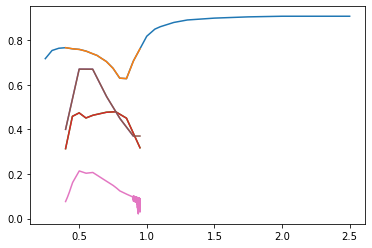

relevant indices shape: (4322,)
bandpass_index shape: (4322,)
bandpass_index numbers: [   0    1    2 ... 4319 4320 4321]
throughput degrade =  {'lam': array([-1.84538106, -1.84422633, -1.84307159, ...,  3.14191686,
        3.14307159,  3.14422633]), 'flux': array([0.03816572, 0.03816572, 0.03816572, ..., 0.02275331, 0.02275331,
       0.02275331])}
Throughput_degrade pre truncation =  (4322,)
Throughput_degrade post truncation =  (4322,)
Background_degrade pre truncation =  (4322,)
Background_degrade post truncation =  (4322,)
using 'mag' to normalize spectrum
nanmean=  0.0027247981331509096
center_w =  0.65
f_nu_AB=  48.59
bkg_mag= 26.236241054433904
this is the background final length: 4322
signal_spectrum = [  0.           0.           0.         ... 183.83450267 183.76696364
 183.69947421]
backgroun final 0-10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
noise sum:  189995.7589615286
signal final sum:  2799061.1169449566
signal sum/noise sum 14.732229457351867
Avg throughput:  0.0488121837534

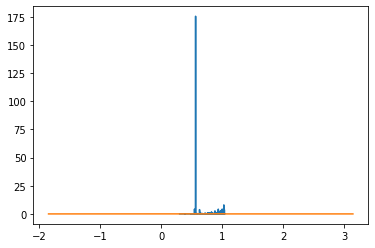

In [156]:
# test out the function

userinput = {"telescope": "SOAR",  #choices are "SOAR", "Gemini", "ATLAS_PROBE" 
             "instrument": "SAMOS",#choices are "SAMOS", "SCORPIO", ,GMOX", ATLAS"
            "band": "LowWhite",      #other choices are 
                                  # SAMOS: "LowRed", "LowBlue", "HighRed", "HighBlue", "LowWhite"
                                  # SCORPIO: "g", "r", "i", "z", "Y", "J", "H", "K"
                                  # GMOX: "Blue", "Red", "J", "H", "K"
                                  # ATLAS: "atlas_IR"
            "slit_width":1.0,    #(arcsec) - Other choices are 
                                  # SAMOS: 0.167, 0.333, 0.500, 0.667, 0.833, 1.000
                                  # SCORPIO: 0.36, 0.54, 0.72, 1.08, 1.44, 2.16, 4.32
                                  # GMOX: 0.083, 0.167, 0.250, 0.333, 0.417, 0.500, 0.583, 0.667, 0.750, 0.833, 0.917, 1.00 
                                  # ATLAS: 0.75             
            "time":3600,          #exposure time (s)
            "nExp":5,             # Nr of frames; increases RON, helps saturation, always dither=2 if >0
            "Nreads":1,           # for IRs, RON goes with SQRT(Nreads), so this is the Nr of Fowler pairs
                                  # for CCDs  (all VIS channels) use Nreads = 1 
            "theta":1.0,          # extension of the source in the cross dispersion direction (arcsec): choice: theta = slitwidth in slitless mode
            "lineF":-99,          #use -99 for a dummy value
            "lineW":-99,          #use -99 for a dummy value
            "FWHM":200,           #Width of the line as emitted by the source, in km/s 
            "z":0,
            "specFile":"./templates/Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt", 
            "mag":22.5,
            "NormalizeUserSpec":True,
            "InputInAngstroms":True,
            "SN":-99,             # = -99 to calculate; othersise set "SN"  > 0 to extract time needed to reach the given SNR
            }
gotit = set_telescope_instrument(userinput)
telescope=gotit['telescope']
instrument=gotit['instrument']

#telescope = dict(gotit)
#instrument = dict(gotit)
#print(telescope)
#print(instrument)
etc_output = general_etc_serena(userinput)

fig = go.Figure(data=[go.Table(header=dict(values=['Variable', 'Value', 'Units']),
                 cells=dict(values=[
                     etc_output["summary_struct"]['quant'],
                     etc_output["summary_struct"]['value'],
                     etc_output["summary_struct"]['unit']]))
                     ])

fig.show()



In [151]:
# For the plots, extract the arrays
# THIS IS NOW A FUNCTION CALLED PLOT_ETC_RESULTS

def plot_etc_results(etc_output_dict):
    
    
    bandpass=etc_output_dict['spec_struct']["spec_bandpass"]
    wl_0=bandpass[0,0]
    wl_1=bandpass[1,0]

    my_dict = dict(values=etc_output_dict["spec_struct"]['wave'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','wl'])
    wl = df['wl'][0]#wl#.plot()

    my_dict = dict(values=etc_output_dict["spec_struct"]['tp'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','tp'])
    tp = df['tp'][0]#wl#.plot()

    my_dict = dict(values=etc_output_dict["spec_struct"]['bandpass'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bandpass'])
    bandpass = df['bandpass'][0]#wl#.plot()

    my_dict = dict(values=etc_output_dict["spec_struct"]['bk'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bk']) 
    bk = df['bk'][0]#wl#.plot()  

    my_dict = dict(values=etc_output_dict["spec_struct"]['signal'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','signal'])
    signal = df['signal'][0]#wl#.plot()

    my_dict = dict(values=etc_output_dict["spec_struct"]['noise'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','noise'])
    noise = df['noise'][0]#wl#.plot()

    my_dict = dict(values=etc_output_dict["spec_struct"]['sn'])
    df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','sn'])
    sn = df['sn'][0]#wl#.plot()
 
    
    my_final_dict = {"wl_0":wl_0,
                     "wl_1":wl_1,
                     "wl": wl,
                     "tp": tp,
                     "bandpass": bandpass,
                     "bk": bk,
                     "signal": signal,
                     "noise": noise,
                     "sn": sn}
       
    #plotting: 
    fig, axs = plt.subplots(2, 3,figsize=(20, 10))
    axs[0, 0].plot(wl,tp,label='telescope throughput')
    axs[0, 0].set_xlabel('wavelength (micron)')
    axs[0, 0].set_xlim([wl_0,wl_1])
    axs[0, 0].legend()
    axs[0, 1].plot(wl,bandpass,label='bandpass')
    axs[0, 1].set_xlabel('wavelength (micron)')
    axs[0, 1].set_xlim([wl_0,wl_1])
    axs[0, 1].legend()
    axs[0, 2].plot(wl,bk,label='background')
    axs[0, 2].set_xlabel('wavelength (micron)')
    axs[0, 2].set_ylabel('electrons/pixel')
    axs[0, 2].set_xlim([wl_0,wl_1])
    axs[0, 2].legend()
    #axs[1, 0].plot(wl,sig,label='sig')
    #axs[1, 0].legend()
    axs[1, 0].plot(wl,signal,label='signal')
    axs[1, 0].set_xlabel('wavelength (micron)')
    axs[1, 0].set_ylabel('electrons/pixel')
    #axs[1, 0].set_xlim([wl_0,wl_1])
    axs[1, 0].set_xlim([0,wl_1])
    axs[1, 0].legend()
    axs[1, 1].plot(wl,noise,label='noise')
    axs[1, 1].set_xlabel('wavelength (micron)')
    axs[1, 1].set_ylabel('electrons/pixel')
    axs[1, 1].set_xlim([wl_0,wl_1])
    axs[1, 1].legend()
    axs[1, 2].plot(wl,sn,label='sn')
    axs[1, 2].set_xlabel('wavelength (micron)')
    axs[1, 2].set_ylabel('electrons/pixel')
    axs[1, 2].set_xlim([wl_0,wl_1])
    axs[1, 2].legend()

    return my_final_dict


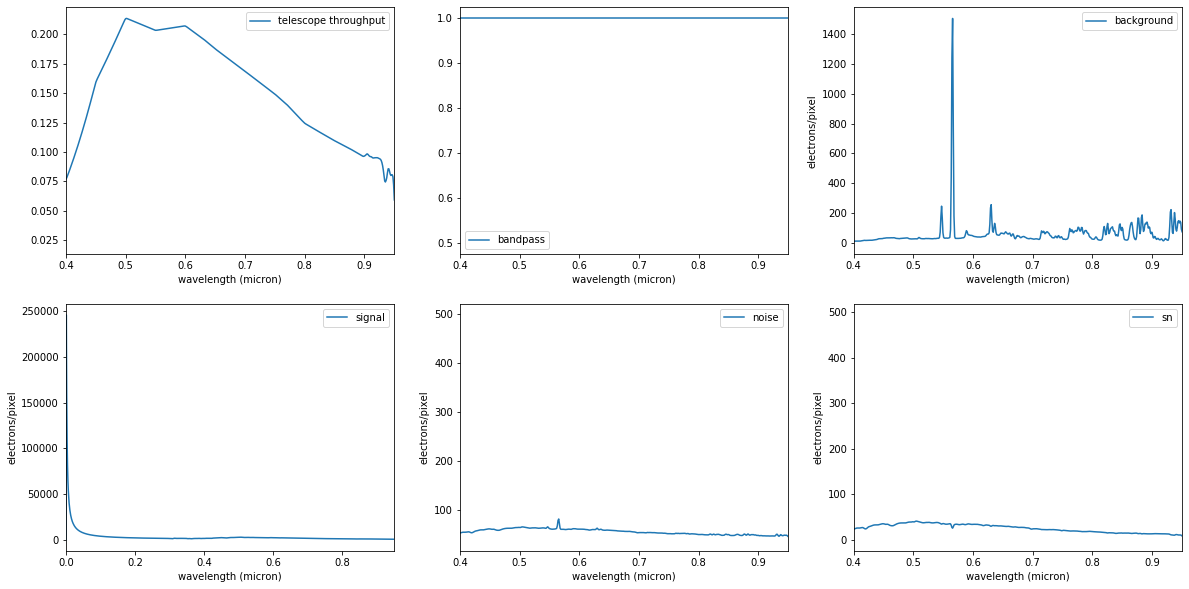

In [152]:
#plot this and reinitiate all the different variables so you have them out and about for further use
etc_output_nofilter = plot_etc_results(etc_output)
wl = etc_output_nofilter["wl"]
tp = etc_output_nofilter["tp"]
bandpass = etc_output_nofilter["bandpass"]
bk = etc_output_nofilter["bk"]
signal = etc_output_nofilter["signal"]
noise = etc_output_nofilter["noise"]
sn = etc_output_nofilter["sn"]
wl_0 = etc_output_nofilter["wl_0"]
wl_1 = etc_output_nofilter["wl_1"]



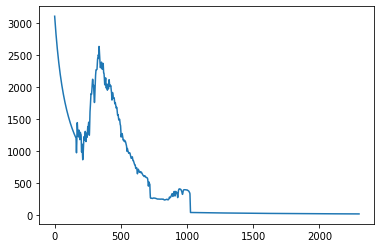

In [166]:
plt.plot(signal[1700:4000])

## Create a new background filter:
- tested blue, just using red to create filter now

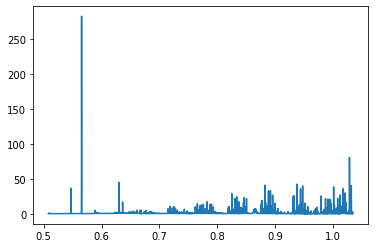

In [67]:
#reload

my_dict = dict(values=etc_output["spec_struct"]['bk'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bk']) 
bk = df['bk'][0]#wl#.plot()  

plt.plot(wl,bk)
#plt.xlim(wl_0,wl_1)


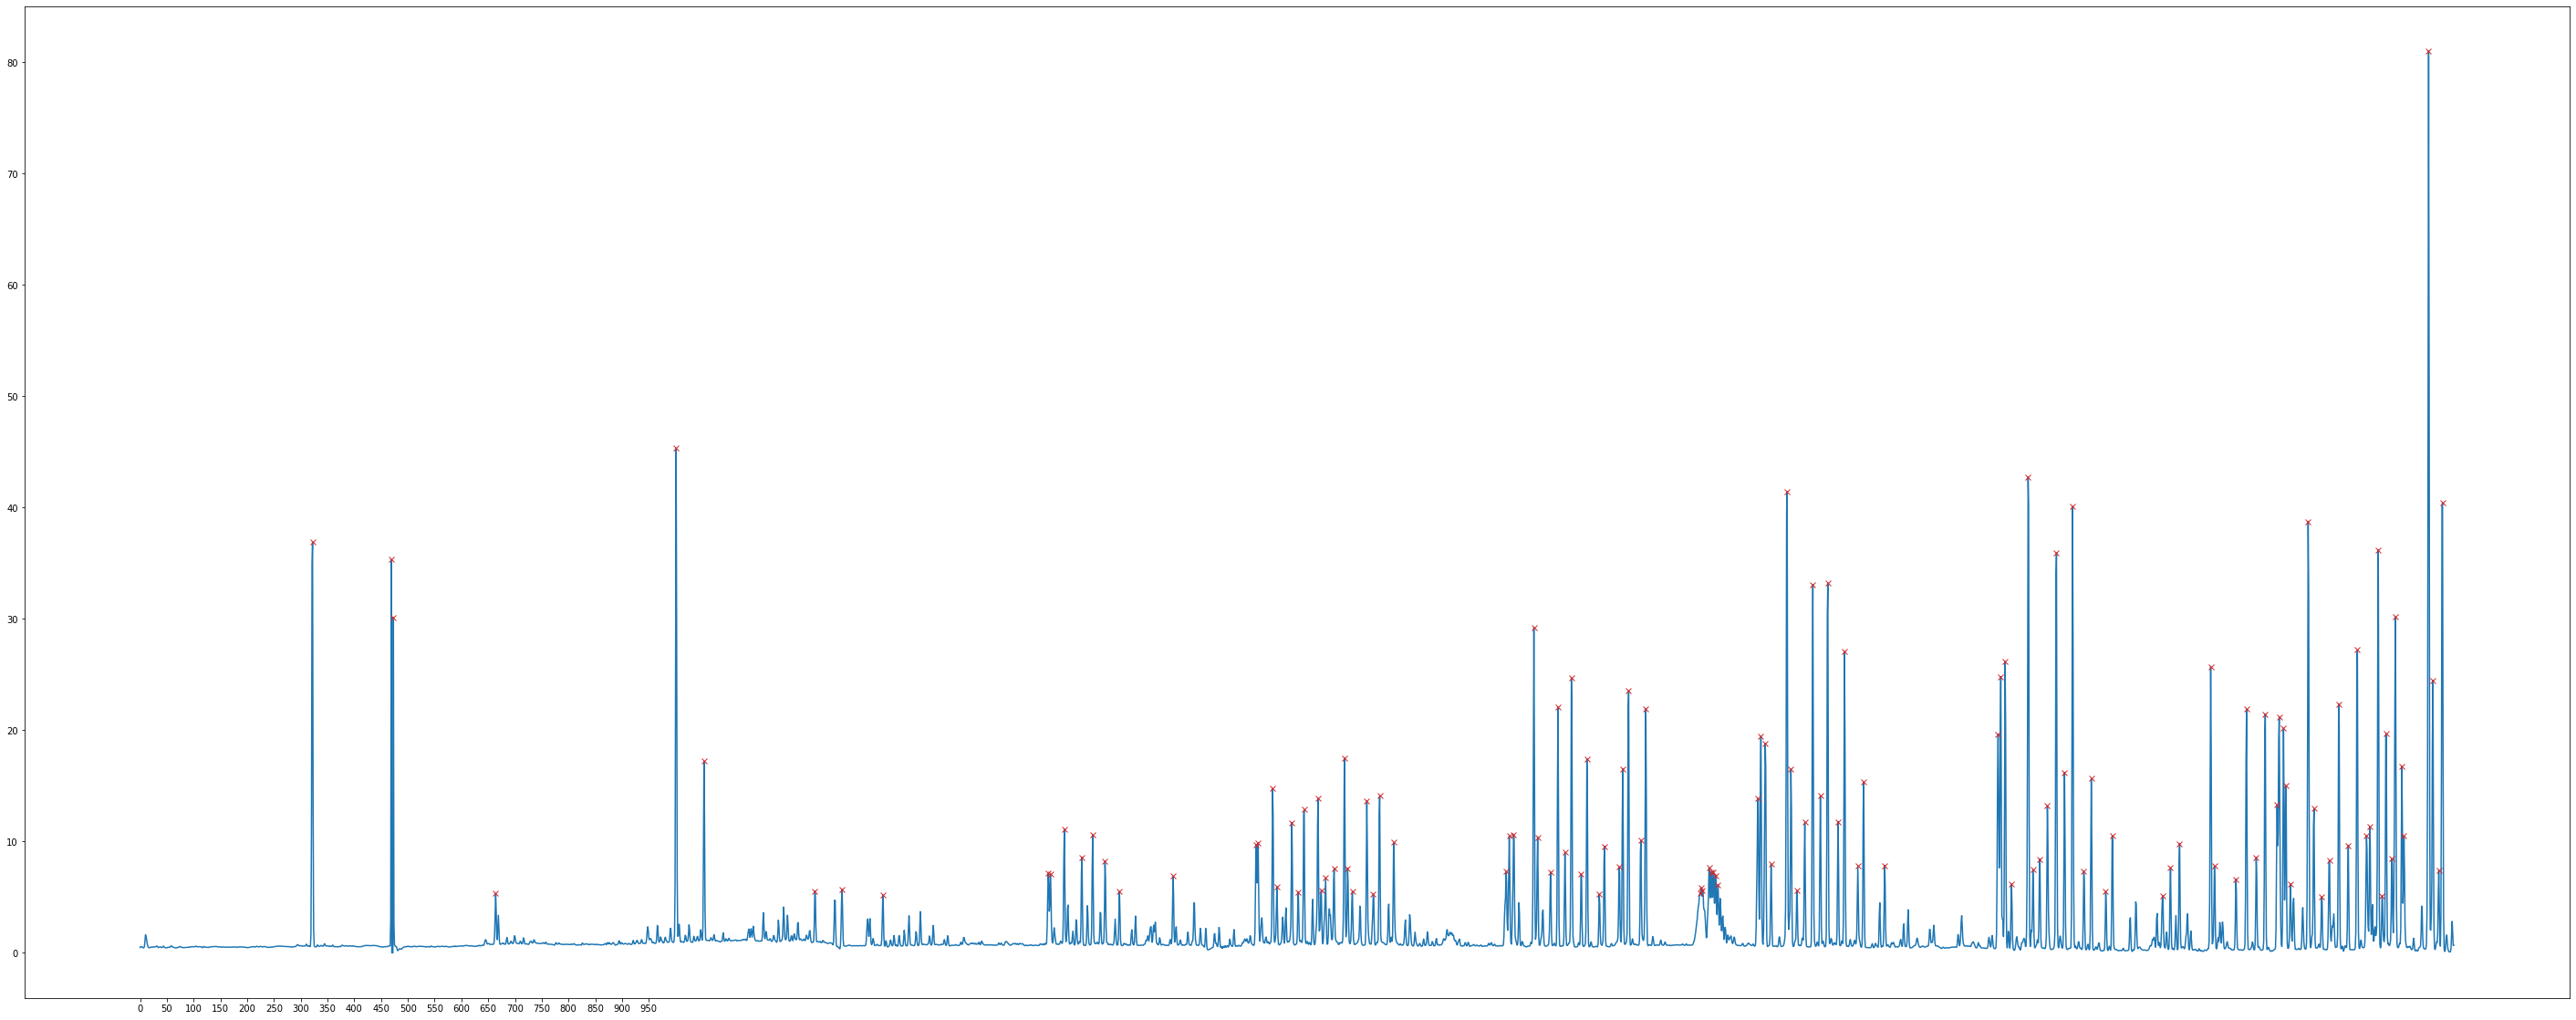

In [68]:
# find peaks, indices
# ---------------- using find peaks just to see what that looks like first ------------------#

# but get rid of extreme outliers first
bk_better = bk
rms_sig = np.sqrt(np.mean(bk_better**2))
rmse_sig = np.sqrt(np.mean((bk_better-rms_sig)**2))
super_outlier = rmse_sig * 15
try1 = np.where(bk_better >= super_outlier)[0]
bk_better[try1] = 0

peaks,_= find_peaks(bk_better, height = 5)
new_peak_ind = wl[peaks]
plt.figure(figsize=(50,20))
plt.plot(bk_better)
plt.plot(peaks,bk_better[peaks],"x", color='#d62728')

plt.xticks(np.arange(0, 1000, step=50))
# plt.plot(wl,bk)
# plt.plot(new_peak_ind,bk[peaks], "x", color='#d62728')
# plt.xlim([wl_0,wl_1])
plt.show()


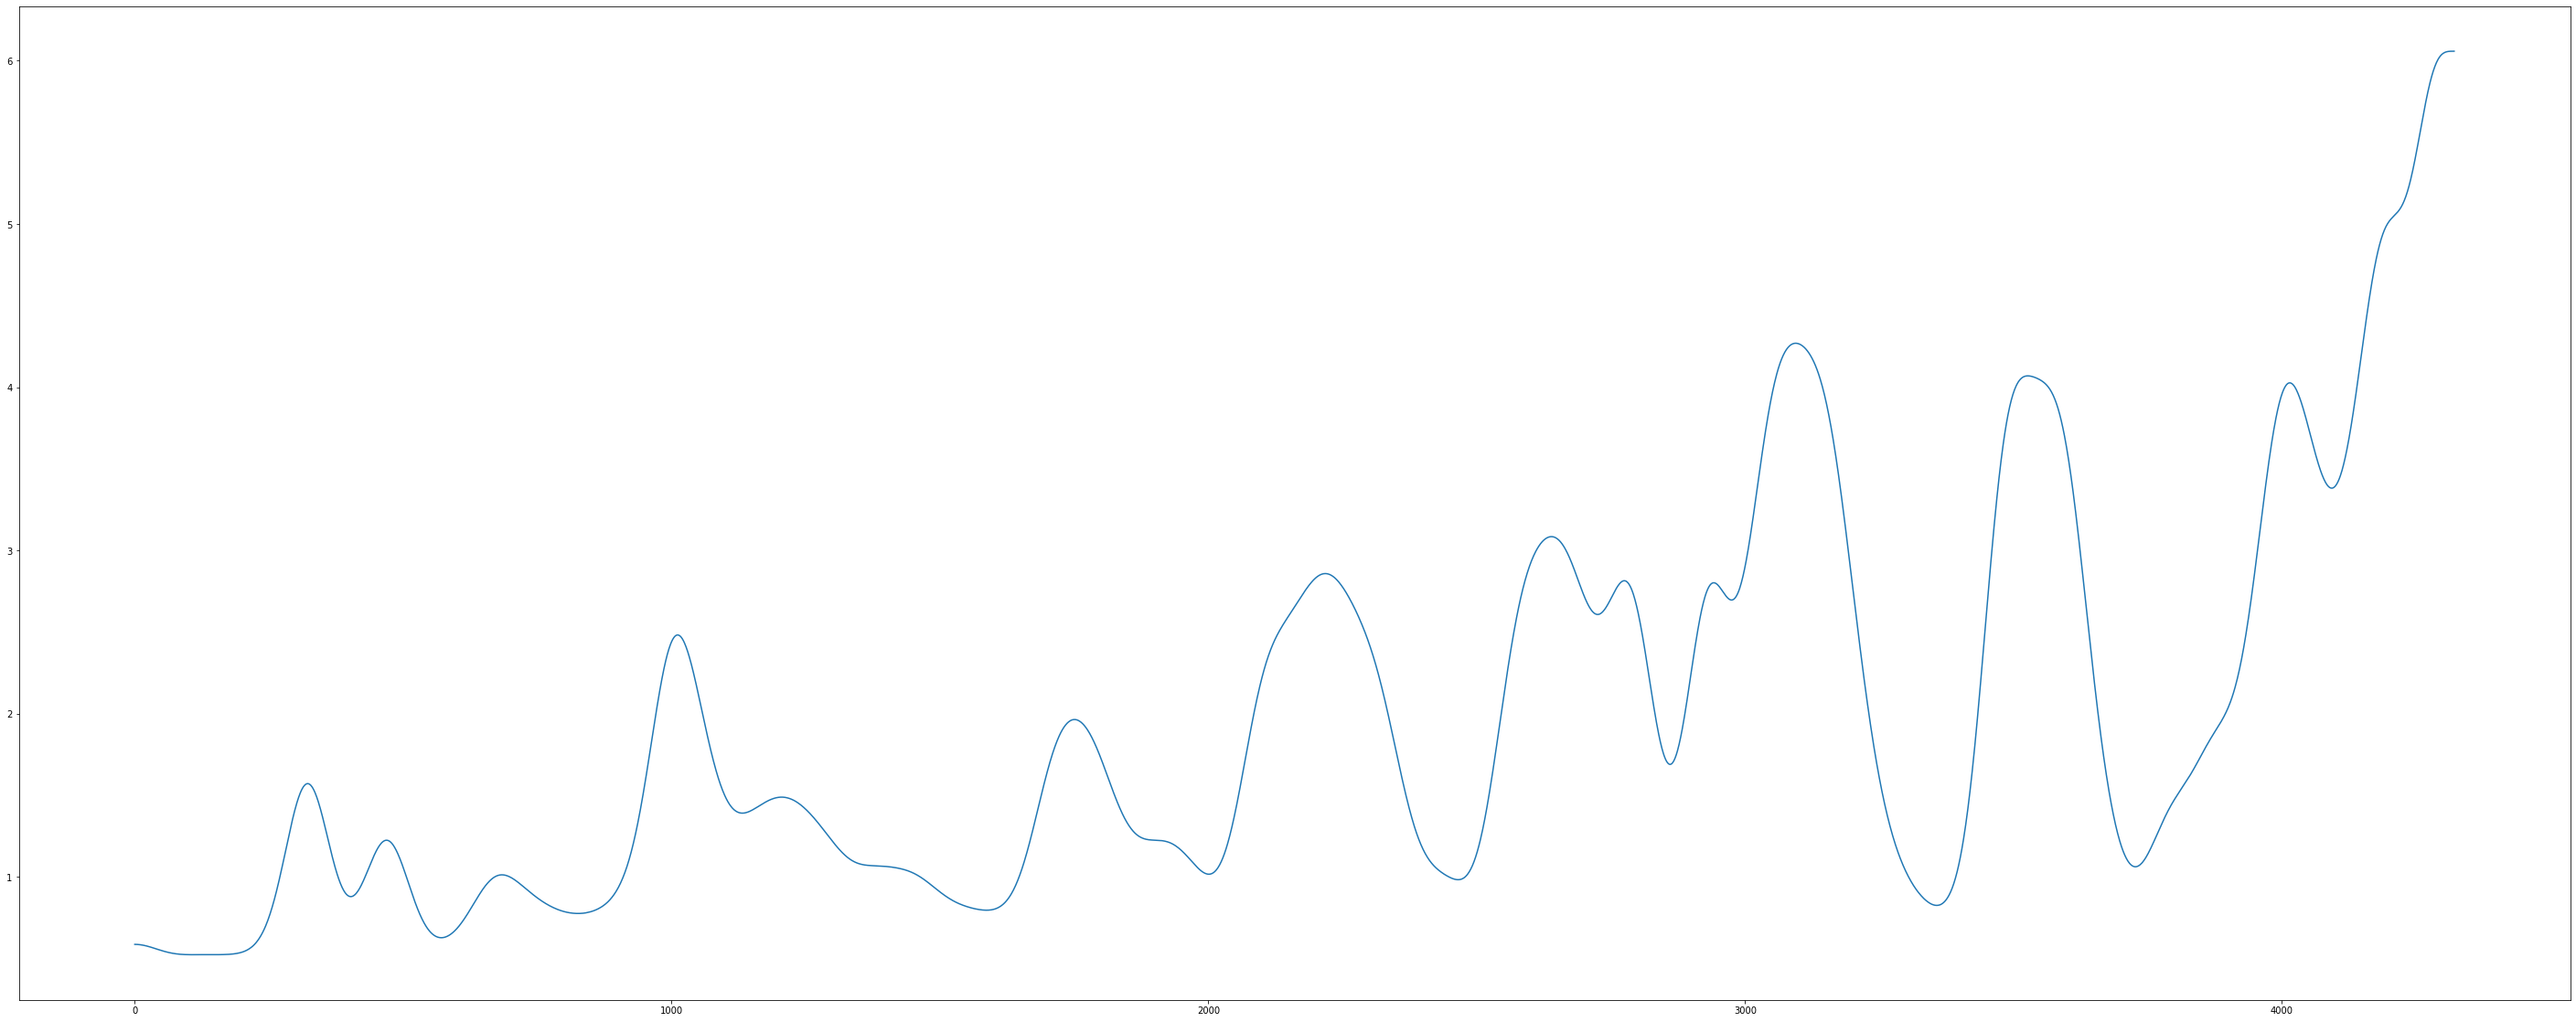

In [69]:
# ---------------- using gaussian filter ------------------#

plt.figure(figsize=(50,20))
gauss_pass = gaussian_filter(bk_better, sigma=40, mode = 'mirror')
plt.plot(gauss_pass)



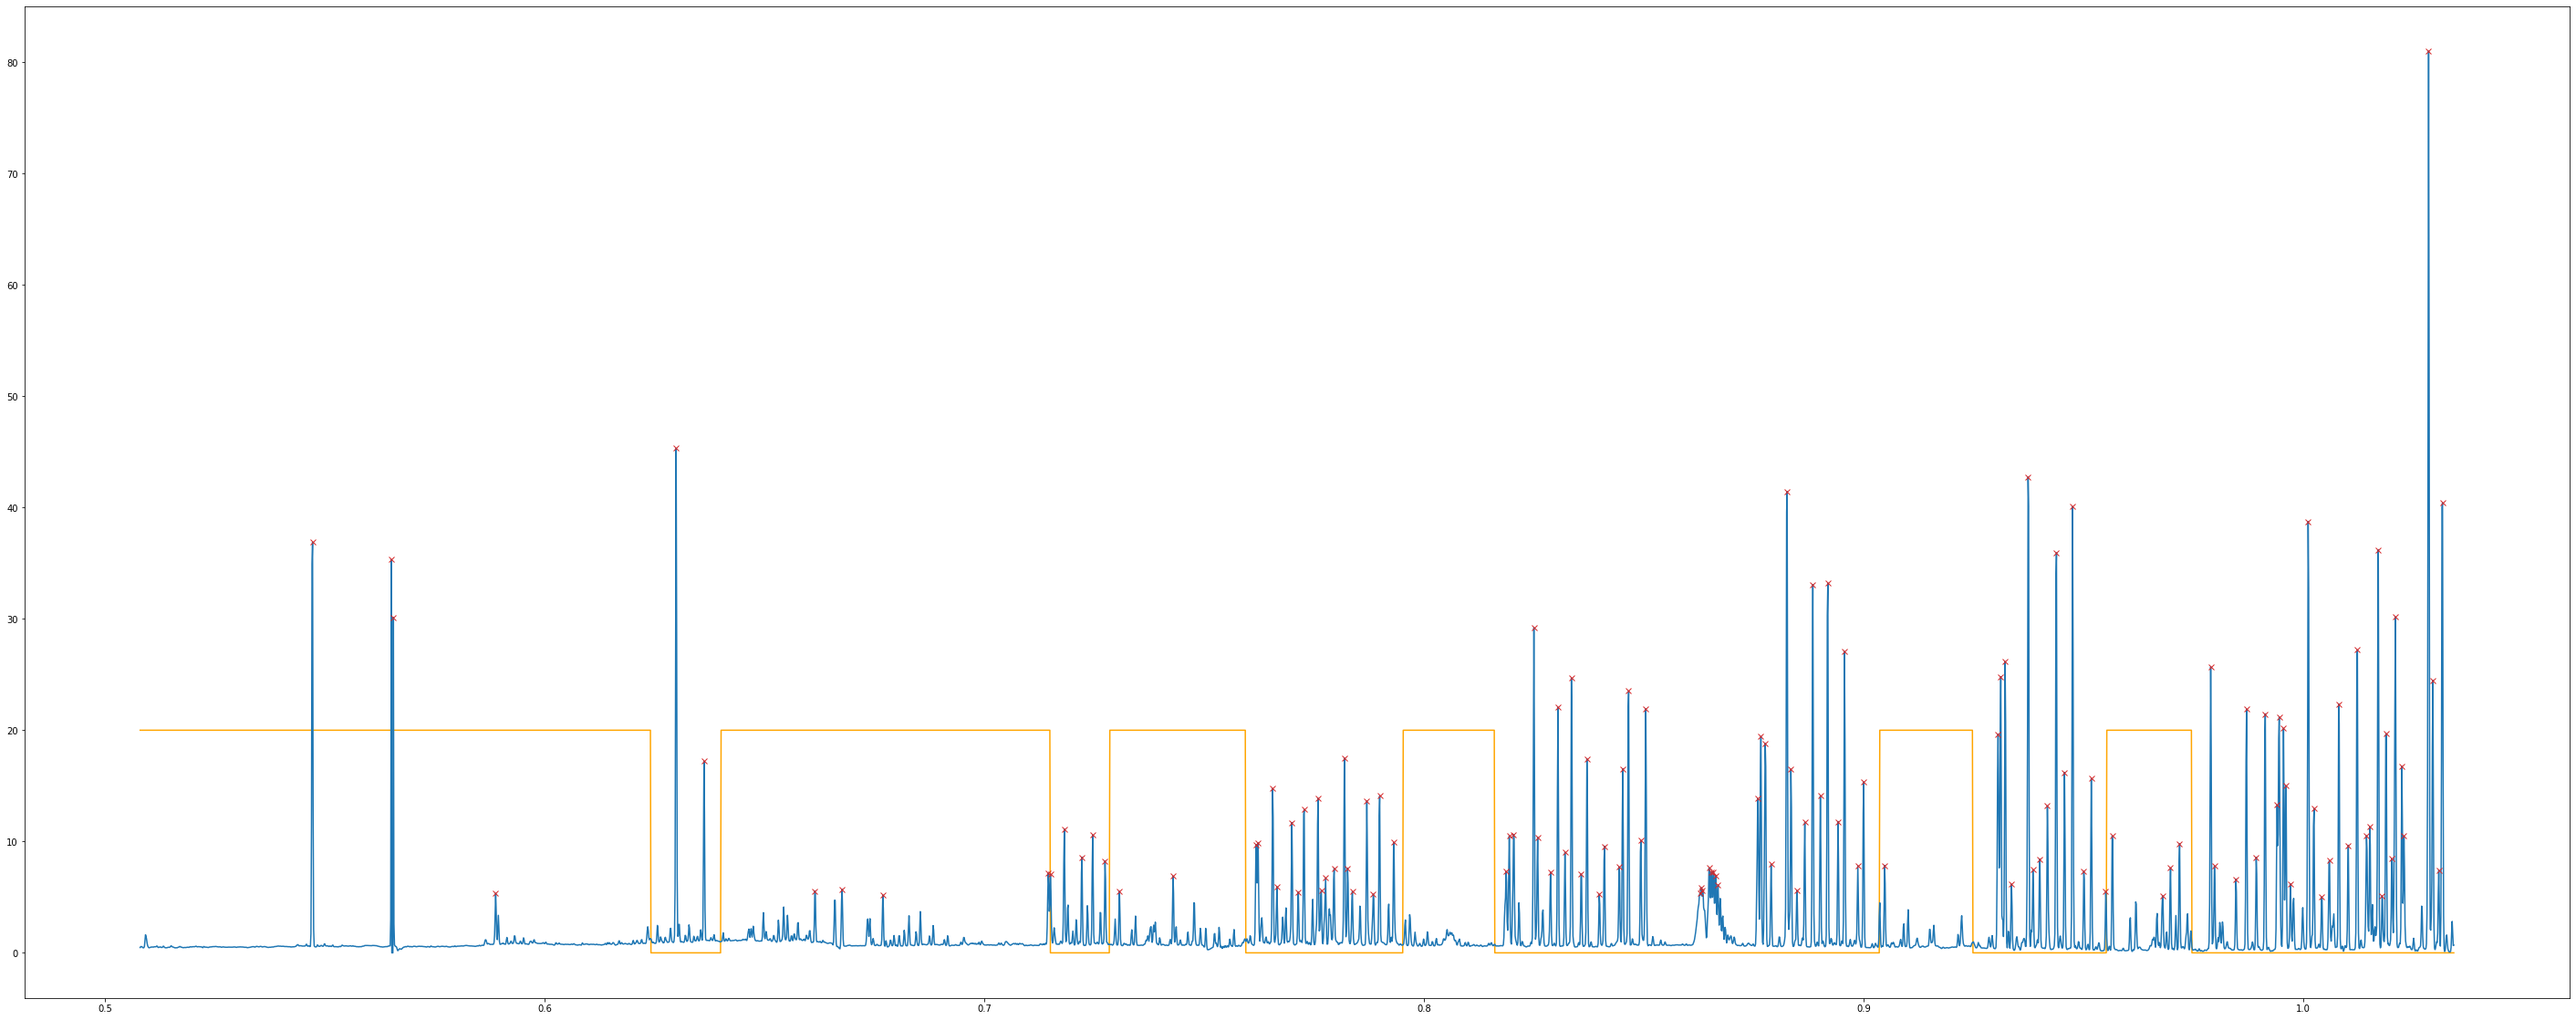

In [70]:
#### THE OKAY BACKGROUND FILTER
######### background filter >>>>> realistic one, gaussian motivated filter

#----------create threshold: CAN EDIT THIS (sigma or threshold)------#
gauss_pass = gaussian_filter(bk_better, sigma=40, mode = 'mirror')
threshold = (max(gauss_pass)) * .27


#create background filter
# THIS IS THE IMPORTANT GUY
bk_filter_gauss = 1 * (gauss_pass < threshold)

#plot
bk_filter_gauss_plot = 20 * bk_filter_gauss
plt.figure(figsize=(50,20))
plt.plot(wl,bk_filter_gauss_plot, color = 'orange')
plt.plot(wl,bk_better)
plt.plot(new_peak_ind,bk_better[peaks], "x", color='#d62728')

#plt.xlim([wl_0,wl_1])

plt.show()



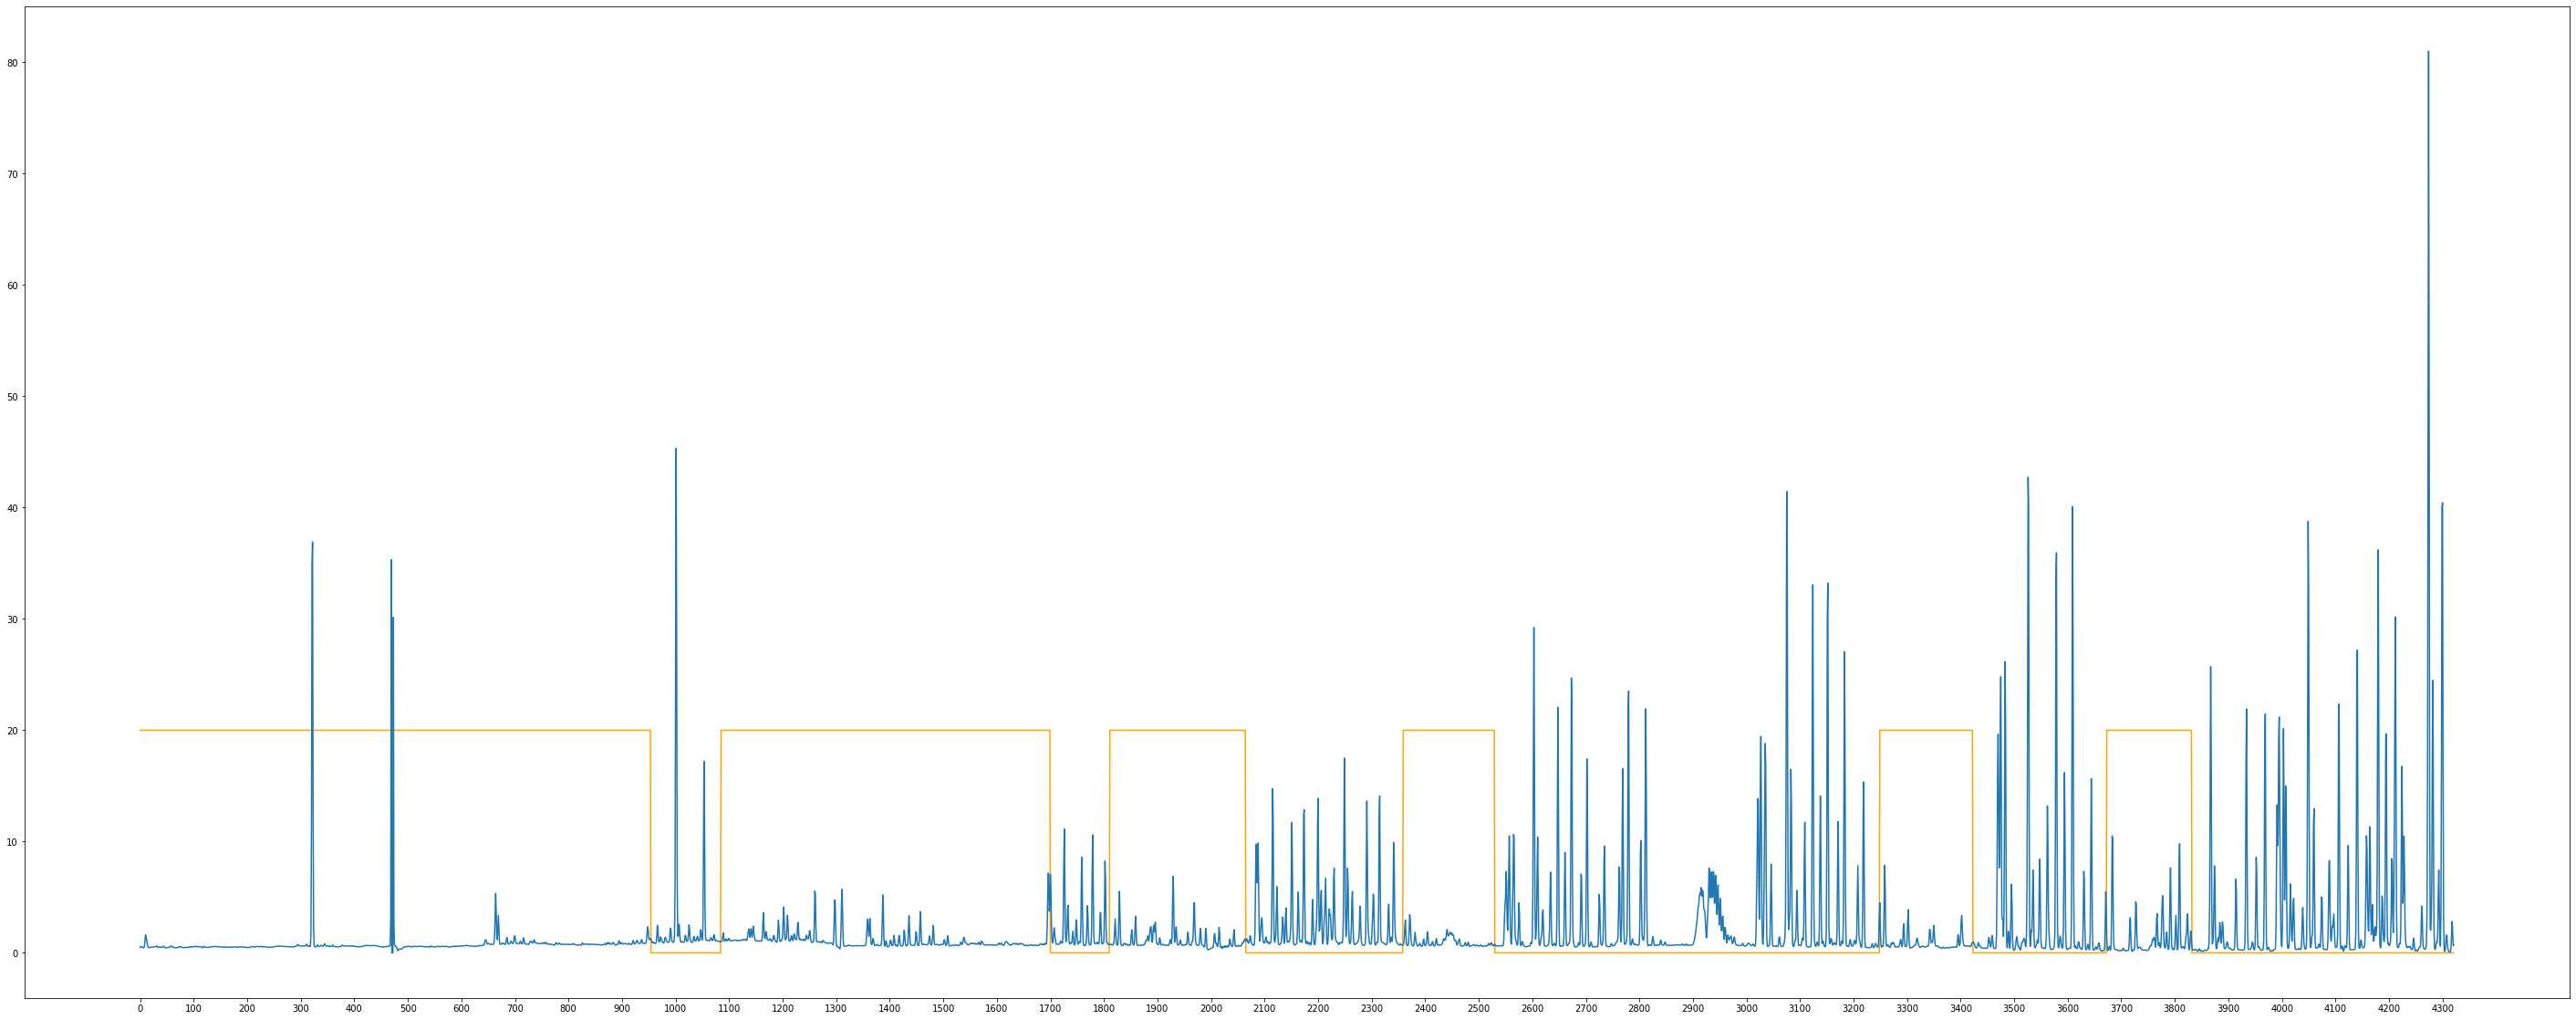

In [71]:
# Changing filter to have larger blocks

########----------- try to do it automated: ----------------#########

# ideas for making it work for both kinds of filters
    # if peak is greater than blah, split into two or three
    # if peak is less than blah, combine into the one next to it

bk_filter_gauss_edited = bk_filter_gauss
    
transition_spots = []
groups = [0]

#marking spots of transition
if bk_filter_gauss_edited[1] > 0:
    for i in np.arange(len(bk_filter_gauss_edited)-1)+1:
        if bk_filter_gauss_edited[i] > 0 and bk_filter_gauss_edited[i+1] == 0:
            groups.append(i)
            if len(groups) == 2:
                transition_spots.append(groups)
                groups = []
        elif bk_filter_gauss_edited[i] > 0 and bk_filter_gauss_edited[i-1] == 0:
            groups.append(i)
            if len(groups) == 2:
                transition_spots.append(groups)
                groups = []

elif bk_filter_gauss_edited[0] == 0:
    for n in np.arange(len(bk_filter_gauss_edited)-1):
        if bk_filter_gauss_edited[n] > 0 and bk_filter_gauss_edited[n-1] == 0:
            transition_spots.append(n)
        elif bk_filter_gauss_edited[n] > 0 and bk_filter_gauss_edited[n+1] == 0:
            transition_spots.append(n)

transition_spots = np.array(transition_spots)
#print((transition_spots))

    
#figuring out the size of each filter block
counter = 0
list_of_lengths = []
for j in np.arange(len(bk_filter_gauss_edited)):
    if bk_filter_gauss_edited[j] != 0:
        counter=counter+1
    elif bk_filter_gauss_edited[j] == 0 and bk_filter_gauss_edited[j-1] > 0:
        list_of_lengths.append(counter)
        counter = 0
        
if bk_filter_gauss_edited[-1] > 0:
    list_of_lengths.append(counter)

list_of_lengths = np.array(list_of_lengths)
#print(list_of_lengths)

for k in list_of_lengths:
    if k > 1500:
        placeholder = 2
    elif k > 2500:
        placeholder =1
        # find indices, place index in thirds = 0
    elif k < 100:
        indicies = transition_spots[np.where(list_of_lengths == k)[0]]
        bk_filter_gauss_edited[indicies[0][0]:indicies[0][1]+1] = 0

# indicies = transition_spots[np.where(list_of_lengths == 39)[0]]
# print([indicies[0][0]:indicies[0][1]])


# check that it works
#plot
bk_filter_gauss_plot = 20*bk_filter_gauss_edited
plt.figure(figsize=(50,20))
plt.plot(bk_filter_gauss_plot, color = 'orange')
plt.plot(bk)
#plt.plot(new_peak_ind,bk[peaks], "x", color='#d62728')
plt.xticks(np.arange(0, 4322, step=100))

#plt.xlim([wl_0,wl_1])

plt.show()





## New Filter Alert: bk_filter_gauss_edited

## Summing 7 regions + new SNR calculation

In [83]:
#-------------sum 7 regions: slit----------#

def bandpass_snr_plot(signal, noise, plotname):

    etc_slit_filtered = signal

    # to split the big boy into two sections
    #etc_slit_filtered = np.insert(etc_slit_filtered,800,0)

    # to calculate the sum for the 7 regions
    section_sum = 0
    list_of_signal = []
    
    # for normalization
    len_sig = []
    counter = 0

    for i in np.arange(len(etc_slit_filtered)):
        if etc_slit_filtered[i] != 0:
            section_sum = section_sum + etc_slit_filtered[i]
            counter=counter+1
        elif etc_slit_filtered[i] == 0 and etc_slit_filtered[i-1] > 0:
            list_of_signal.append(section_sum)
            section_sum=0
            len_sig.append(counter)
            counter = 0
    if etc_slit_filtered[-1] > 0:
        list_of_signal.append(section_sum)
        len_sig.append(counter)

    
    #--------try using the noise calculation with noise------#

    # it doesn't go to 0, is that a problem
    min_noise = min(noise)

    etc_slit_filtered_noise = noise
    #etc_slit_filtered_noise = np.insert(etc_slit_filtered_noise,800,min_noise)


    noise_sum = 0
    list_of_noise = []


    for n in np.arange(len(etc_slit_filtered_noise)):
        if etc_slit_filtered_noise[n] != min_noise:
            noise_sum = noise_sum + (etc_slit_filtered_noise[n])**2
        elif etc_slit_filtered_noise[n] == min_noise and etc_slit_filtered_noise[n-1] > min_noise:
            list_of_noise.append(np.sqrt(noise_sum))
            noise_sum=0
    if etc_slit_filtered_noise[-1] > min_noise:
        list_of_noise.append(np.sqrt(noise_sum))
        
    
    list_of_signal_norm = np.array(list_of_signal)/np.array(len_sig)
    list_of_noise_norm = np.array(list_of_noise)/np.array(len_sig)
    
    #plt.figure(figsize=(50,20))
    xaxis_simple = np.arange(len(list_of_signal_norm))+1
    plt.scatter(xaxis_simple,list_of_signal_norm)
    plt.errorbar(xaxis_simple,list_of_signal_norm,yerr=list_of_noise_norm,linestyle="none")
    plt.title(plotname)
    plt.show()

    
    return list_of_signal_norm, list_of_noise_norm

## ETC: fliter, slitless - default userinput
- in the end we want to get this back, but just keeping this for now


(9, 2) (9, 2) (9, 2) (7199, 2)
(203189, 2)


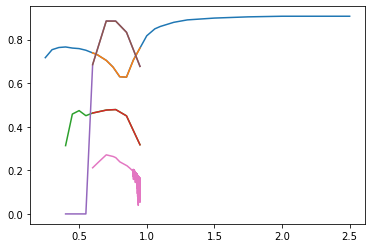

relevant indices shape: (4322,)
bandpass_index shape: (4322,)
bandpass_index numbers: [   0    1    2 ... 4319 4320 4321]
Throughput_degrade pre truncation =  (4322,)
Throughput_degrade post truncation =  (4322,)
Background_degrade pre truncation =  (4322,)
Background_degrade post truncation =  (4322,)
using 'mag' to normalize spectrum
nanmean=  0.0036678842105322684
center_w =  0.7712
f_nu_AB=  48.59
bkg_mag= 25.72790368346446
this is the background final length: 4322
backgroun final 0-10: [0.00013325 0.00015268 0.00015734 0.0001528  0.00014414 0.00012983
 0.00012475 0.00012882 0.00015979 0.00030272]
noise sum:  352617.054687386
signal final sum:  241955.28950386355
signal sum/noise sum 0.6861701278696516


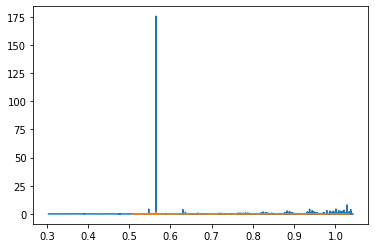

In [84]:
#### RUN THE BIG BOI ETC AGAIN, SLITLESS + FILTER

slitless_filtered_etc_output = general_etc_serena(userinput, filtered=True, bandpass_filter=bk_filter_gauss_edited,slitless_mode=True)

fig = go.Figure(data=[go.Table(header=dict(values=['Variable', 'Value', 'Units']),
                 cells=dict(values=[
                     slitless_filtered_etc_output["summary_struct"]['quant'],
                     slitless_filtered_etc_output["summary_struct"]['value'],
                     slitless_filtered_etc_output["summary_struct"]['unit']]))
                     ])

fig.show()


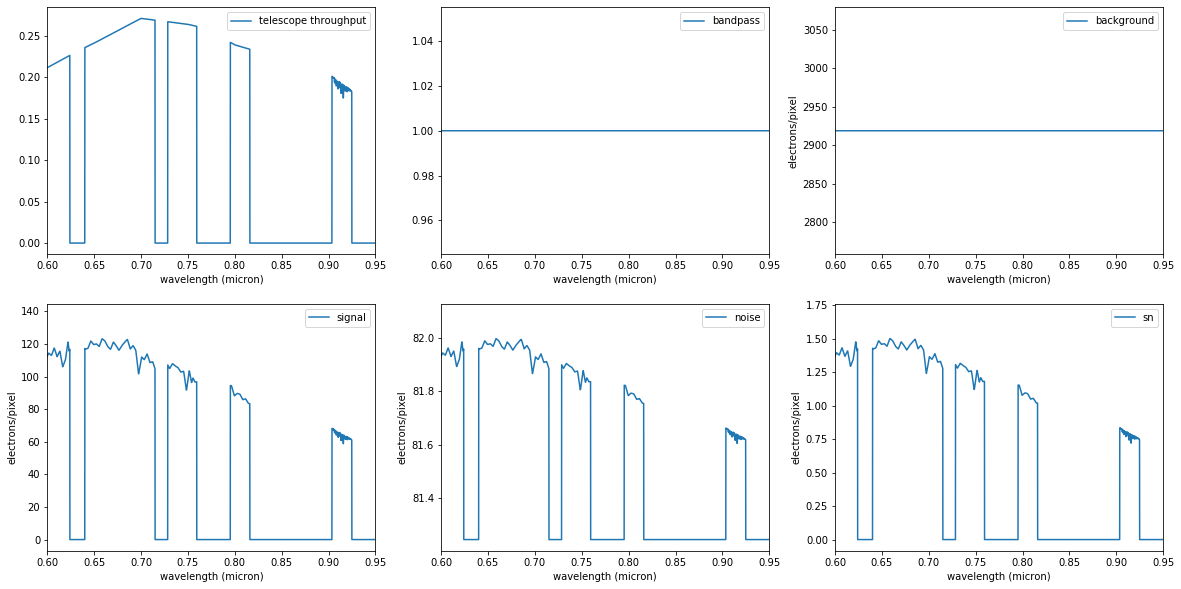

In [85]:
# plot etc slitless filter mode

etc_output_filter_slitless = plot_etc_results(slitless_filtered_etc_output)
wl = etc_output_filter_slitless["wl"]
tp = etc_output_filter_slitless["tp"]
bandpass = etc_output_filter_slitless["bandpass"]
bk = etc_output_filter_slitless["bk"]
signal_slitless = etc_output_filter_slitless["signal"]
noise_slitless = etc_output_filter_slitless["noise"]
sn = etc_output_filter_slitless["sn"]

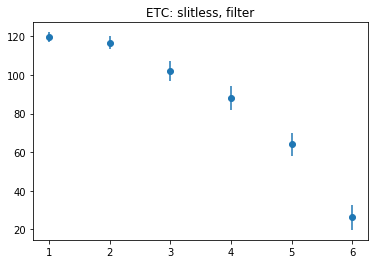

My list of new SNR with slit, filtered:
                 SNR
bandpass1  45.015694
bandpass2  35.286925
bandpass3  19.859235
bandpass4  14.080267
bandpass5  10.334701
bandpass6   4.050367


In [92]:
list_of_signal_slitlessfilter, list_of_noise_slitless_filter = bandpass_snr_plot(signal_slitless,noise_slitless,"ETC: slitless, filter")
print("My list of new SNR with slit, filtered:")

default_slitless = pd.DataFrame(index = ["bandpass1", "bandpass2", "bandpass3","bandpass4","bandpass5","bandpass6"], columns = ["SNR"], data = np.array(list_of_signal_slitlessfilter)/np.array(list_of_noise_slitless_filter))
print(default_slitless)

## ETC: no filter, slitless - new userinput

(9, 2) (9, 2) (9, 2) (7199, 2)
(203189, 2)


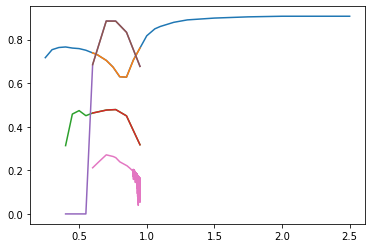

relevant indices shape: (4322,)
bandpass_index shape: (4322,)
bandpass_index numbers: [   0    1    2 ... 4319 4320 4321]
Throughput_degrade pre truncation =  (4322,)
Throughput_degrade post truncation =  (4322,)
Background_degrade pre truncation =  (4322,)
Background_degrade post truncation =  (4322,)
using 'mag' to normalize spectrum
nanmean=  0.014760673982061077
center_w =  0.7712
f_nu_AB=  48.59
bkg_mag= 24.216177256199913
this is the background final length: 4322
backgroun final 0-10: [8.79446085e-05 1.00771957e-04 1.03845710e-04 1.00848809e-04
 9.51345651e-05 8.56868258e-05 8.23367936e-05 8.50232298e-05
 1.05461837e-04 1.99792821e-04]
noise sum:  485118.3193880841
signal final sum:  374795.03060468985
signal sum/noise sum 0.7725847811260699


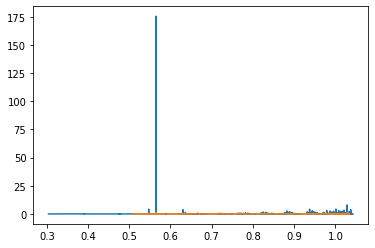

In [95]:
userinput_slitless = {"telescope": "SOAR",  #choices are "SOAR", "Gemini", "ATLAS_PROBE" 
             "instrument": "SAMOS",#choices are "SAMOS", "SCORPIO", ,GMOX", ATLAS"
            "band": "LowRed",      #other choices are 
                                  # SAMOS: "LowRed", "LowBlue", "HighRed", "HighBlue", "White1"
                                  # SCORPIO: "g", "r", "i", "z", "Y", "J", "H", "K"
                                  # GMOX: "Blue", "Red", "J", "H", "K"
                                  # ATLAS: "atlas_IR"
            "slit_width":0.33,    #(arcsec) - Other choices are 
                                  # SAMOS: 0.167, 0.333, 0.500, 0.667, 0.833, 1.000
                                  # SCORPIO: 0.36, 0.54, 0.72, 1.08, 1.44, 2.16, 4.32
                                  # GMOX: 0.083, 0.167, 0.250, 0.333, 0.417, 0.500, 0.583, 0.667, 0.750, 0.833, 0.917, 1.00 
                                  # ATLAS: 0.75             
            "time":3600,          #exposure time (s)
            "nExp":5,             # Nr of frames; increases RON, helps saturation, always dither=2 if >0
            "Nreads":1,           # for IRs, RON goes with SQRT(Nreads), so this is the Nr of Fowler pairs
                                  # for CCDs  (all VIS channels) use Nreads = 1 
            "theta":0.33,          # extension of the source in the cross dispersion direction (arcsec): choice: theta = slitwidth in slitless mode
            "lineF":-99,          #use -99 for a dummy value
            "lineW":-99,          #use -99 for a dummy value
            "FWHM":200,           #Width of the line as emitted by the source, in km/s 
            "z":0,
            "specFile":"./templates/Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt", 
            "mag":22.5,
            "NormalizeUserSpec":True,
            "InputInAngstroms":True,
            "SN":-99,             # = -99 to calculate; othersise set "SN"  > 0 to extract time needed to reach the given SNR
            }

slitless_nofilter_etc_output = general_etc_serena(userinput_slitless,slitless_mode=True)

fig = go.Figure(data=[go.Table(header=dict(values=['Variable', 'Value', 'Units']),
                 cells=dict(values=[
                     slitless_nofilter_etc_output["summary_struct"]['quant'],
                     slitless_nofilter_etc_output["summary_struct"]['value'],
                     slitless_nofilter_etc_output["summary_struct"]['unit']]))
                     ])
fig.show()



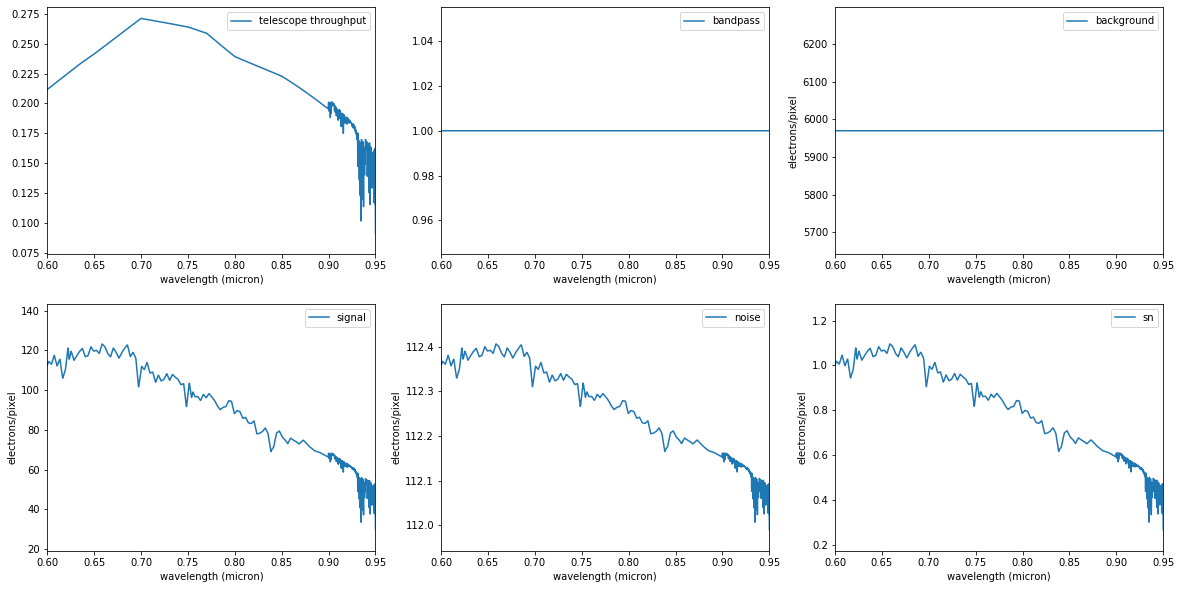

In [97]:
# plot etc slitless nofilter mode

etc_output_nofilter_slitless = plot_etc_results(slitless_nofilter_etc_output)
wl = etc_output_nofilter_slitless["wl"]
tp = etc_output_nofilter_slitless["tp"]
bandpass = etc_output_nofilter_slitless["bandpass"]
bk = etc_output_nofilter_slitless["bk"]
signal_slitless = etc_output_nofilter_slitless["signal"]
noise_slitless = etc_output_nofilter_slitless["noise"]
sn = etc_output_nofilter_slitless["sn"]

## making pretty graphs

In [109]:
# working with signal_slitless
# Use to represent decreasing SNR later:
    #fig = go.Figure(data=[go.Table(header=dict(values=['Variable', 'Value', 'Units']),
    #                  cells=dict(values=[
    #                      slitless_nofilter_etc_output["summary_struct"]['quant'],
    #                      slitless_nofilter_etc_output["summary_struct"]['value'],
    #                      slitless_nofilter_etc_output["summary_struct"]['unit']]))
    #                      ])
    # fig.show()


# plan:
    # split signal into groups of 2, 6, 10, 20, 50, 100, 200 > we'll call it groups2, groups3, gp100, etc
    # use the bandpass_snr_plot: bandpass_snr_plot(signal, noise, plotname):
    # use dataframe to depict the different SNRs (pd.concat([df,df1], ignore_index=True, axis=1))
    # graph signal with noise as error bars i guess? in a subplot?
    # and then do the final one
    # can put all of this into a function at the end
    
    
# do i put a 0 in each place or just make the groups? 
# just making the groups for now
    
#group 2
group2_sig = []
group2_noise = []
for s in np.arange(len(signal_slitless)-1):
    group2_sig.append(signal_slitless[s]+signal_slitless[s+1])
for n in np.arange(len(noise_slitless)-1):
    group2_noise.append(np.sqrt((noise_slitless[n]**2+noise_slitless[n+1]**2)))

#group 6   
# group6_sig = []
# group6_noise = []
# for s in np.arange(len(signal_slitless)-6):
#     group6_sig.append(np.sum(signal_slitless[s]:signal_slitless[s+6]))
# for n in np.arange(len(noise_slitless)-1):
#     group6_noise.append(np.sqrt((noise_slitless[n]**2+noise_slitless[n+1]**2)))


np.sum([1:5])

#plt.scatter(np.arange(len(group2_sig)),group2_sig, s=0.2)    


# sum every 2 points
    # this is a new data point
# quad sum two noise points
    # this is new noise data point

    



SyntaxError: invalid syntax (<ipython-input-109-66730f021402>, line 41)